### Описание задачи

В некой стране Компания производит различные товары-сладости (SKU) и осуществляет продажу в 4х туристических городах (локациях), где количество и тип потребителей меняется от месяца к месяцу. Основную часть ассортимента Компании составляет шоколад, а основной объем продаж приходится на город Alpha City.

Компании доступно 2 источника информации, оба помесячные: внутренние данные по отгрузкам и розничным ценам в каждом из 4х городов, а также внешние данные, которые компания закупает у стороннего подрядчика, по количеству и типам клиентов в городах. 

Данные по продажам - sales.tsv  
Данные по потоку потребителей - customers.tsv

 - sku_id = уникальный идентификатор одной позиции товара (SKU = Stock Keeping Unit).  
 - ira = International Retail Association  = уникальный код локации согласно классификации международной ассоциации ретейлеров.  
 - product_category – категория продукта.  
 - item_per_bundle – количество единиц товара на 1 упаковку (например, бывают наборы по 3 шоколадки сразу).  
 - shape – форма упаковки.  
 - with_alcohol – содержит ли алкоголь в начинке (yes/no).  
 - filling – начинка.  
 - volume – объем продаж в штуках.  
 - price – цена 1 штуку товара в USD.  

Данные по типу и количеству клиентов (потоку клиентов), имеет глубокую экспертизу и дополнительные внешние источники (например, забронированные путевки), на основании которых предоставляет как фактические данные (до июня 2019 года включительно), так и достаточно точной прогноз на 3 месяца вперед (июль-сентября 2019)

Сейчас 01 июля 2019 года, Компания только что получила свежие данные по продажам до июня включительно. Вас, как специалиста по продвинутой аналитике, наняли для того, чтобы найти алгоритм, максимально точно описывающий поведение рынка, то есть зависимость продаж каждой позиции товара в каждой локации от различных факторов. 

## Задача 1

Сейчас 01 июля 2019 года, нужно спрогнозировать продажи по каждому SKU в ассортименте для каждой локации на 3 месяца вперед помесячно (июль, август, сентябрь) с предположением, что цены останутся неизменными по сравнению с последним месяцем.Точность оценивается по метрике SMAPE.  
Если для какого-то SKU в какой-то локации прогноз сделать невозможно, необходимо указать причину.

In [1]:
#pip install -r requirements.txt

In [246]:
#pip install statsmodels

In [247]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf

In [248]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


#### Загрузка данных

In [4]:
df_s = pd.read_csv("data/sales.tsv", sep='\t')

In [5]:
df_c = pd.read_csv("data/customers.tsv", sep='\t')

In [4]:
df_s.head()

year  month    location ira product_category           brand   sku_id  \
0  2017      1  Alpha City  AC       Chocolates         Cadbury  sku #79   
1  2017      1  Alpha City  AC       Chocolates  Ferrero Rocher  sku #15   
2  2017      1  Alpha City  AC       Chocolates  Ferrero Rocher  sku #16   
3  2017      1  Alpha City  AC       Chocolates  Ferrero Rocher  sku #22   
4  2017      1  Alpha City  AC       Chocolates  Ferrero Rocher  sku #28   

   item_per_bundle     shape with_alcohol  filling   volume     price  
0                1  Standart           No  Nothing   4572.0       NaN  
1                1  Standart           No  Nothing   8028.0  1.221336  
2                3  Standart           No  Nothing   6606.0  2.866401  
3                2  Standart           No  Nothing  11688.0  2.093719  
4                3  Standart           No  Nothing   3582.0  2.866401

In [5]:
df_c.head()

year  month ira customers_type  amount_of_customers
0  2017      1  AC         Archer                679.0
1  2017      1  AC           Monk               1070.0
2  2017      1  AC          Dwarf                610.0
3  2017      1  AC        Centaur               1315.0
4  2017      1  AC        Gremlin               1554.0

#### Работа с пропусками значений

In [9]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980 entries, 0 to 1979
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 1980 non-null   int64  
 1   month                1980 non-null   int64  
 2   ira                  1980 non-null   object 
 3   customers_type       1980 non-null   object 
 4   amount_of_customers  1980 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 77.5+ KB


In [10]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1729 entries, 0 to 1728
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              1729 non-null   int64  
 1   month             1729 non-null   int64  
 2   location          1729 non-null   object 
 3   ira               1729 non-null   object 
 4   product_category  1729 non-null   object 
 5   brand             1729 non-null   object 
 6   sku_id            1729 non-null   object 
 7   item_per_bundle   1729 non-null   int64  
 8   shape             1729 non-null   object 
 9   with_alcohol      1729 non-null   object 
 10  filling           1729 non-null   object 
 11  volume            1729 non-null   float64
 12  price             1617 non-null   float64
dtypes: float64(2), int64(3), object(8)
memory usage: 175.7+ KB


In [11]:
df_s.isnull().sum()

year                  0
month                 0
location              0
ira                   0
product_category      0
brand                 0
sku_id                0
item_per_bundle       0
shape                 0
with_alcohol          0
filling               0
volume                0
price               112
dtype: int64

 Есть пропуски только по ценам (price), посмотрю на эти данные подробнее:

Группировка по товарам с отсутствием записей по ценам:

In [12]:
df_s[df_s.isnull().any(axis=1)]['sku_id'].value_counts()

sku #78     24
sku #79     24
sku #84     12
sku #81     12
sku #82     12
sku #83     12
sku #106     8
sku #97      4
sku #94      3
sku #100     1
Name: sku_id, dtype: int64

По городам:

In [13]:
df_s[df_s.isnull().any(axis=1)]['location'].value_counts()

Moon          48
Alpha City    35
Pirate Bay    29
Name: location, dtype: int64

По годам и месяцам:

In [14]:
df_s[df_s.isnull().any(axis=1)].groupby(['year', 'month'])['sku_id'].count()

year  month
2017  1         8
      2         8
      3         8
      4         8
      5         8
      6         8
      7         8
      8         9
      9        11
      10       11
      11       12
      12       13
Name: sku_id, dtype: int64

Данных не хватает только в 2017 году и в каждом месяце примерно равное количетво пропусков.

In [6]:
df_s['is_nan'] = df_s['price'].apply(lambda x: math.isnan(x))

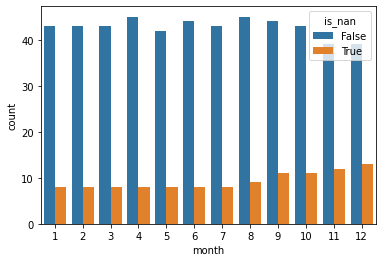

In [16]:
sns.countplot(data=df_s[df_s['year']==2017], x='month', hue='is_nan');

В среднем по месяцам почти 10% данных пустые за 2017 год

In [17]:
df_s['price'].describe()

count    1617.000000
mean        1.583406
std         0.629972
min         1.031200
25%         1.246254
50%         1.295835
75%         1.438110
max         3.632387
Name: price, dtype: float64

Заменю пропуски цен на 0 и посмотрю "просадки" на графиках

In [7]:
df_s['price'].fillna(0, inplace=True)

In [8]:
df_s['price'].isna().sum()

0

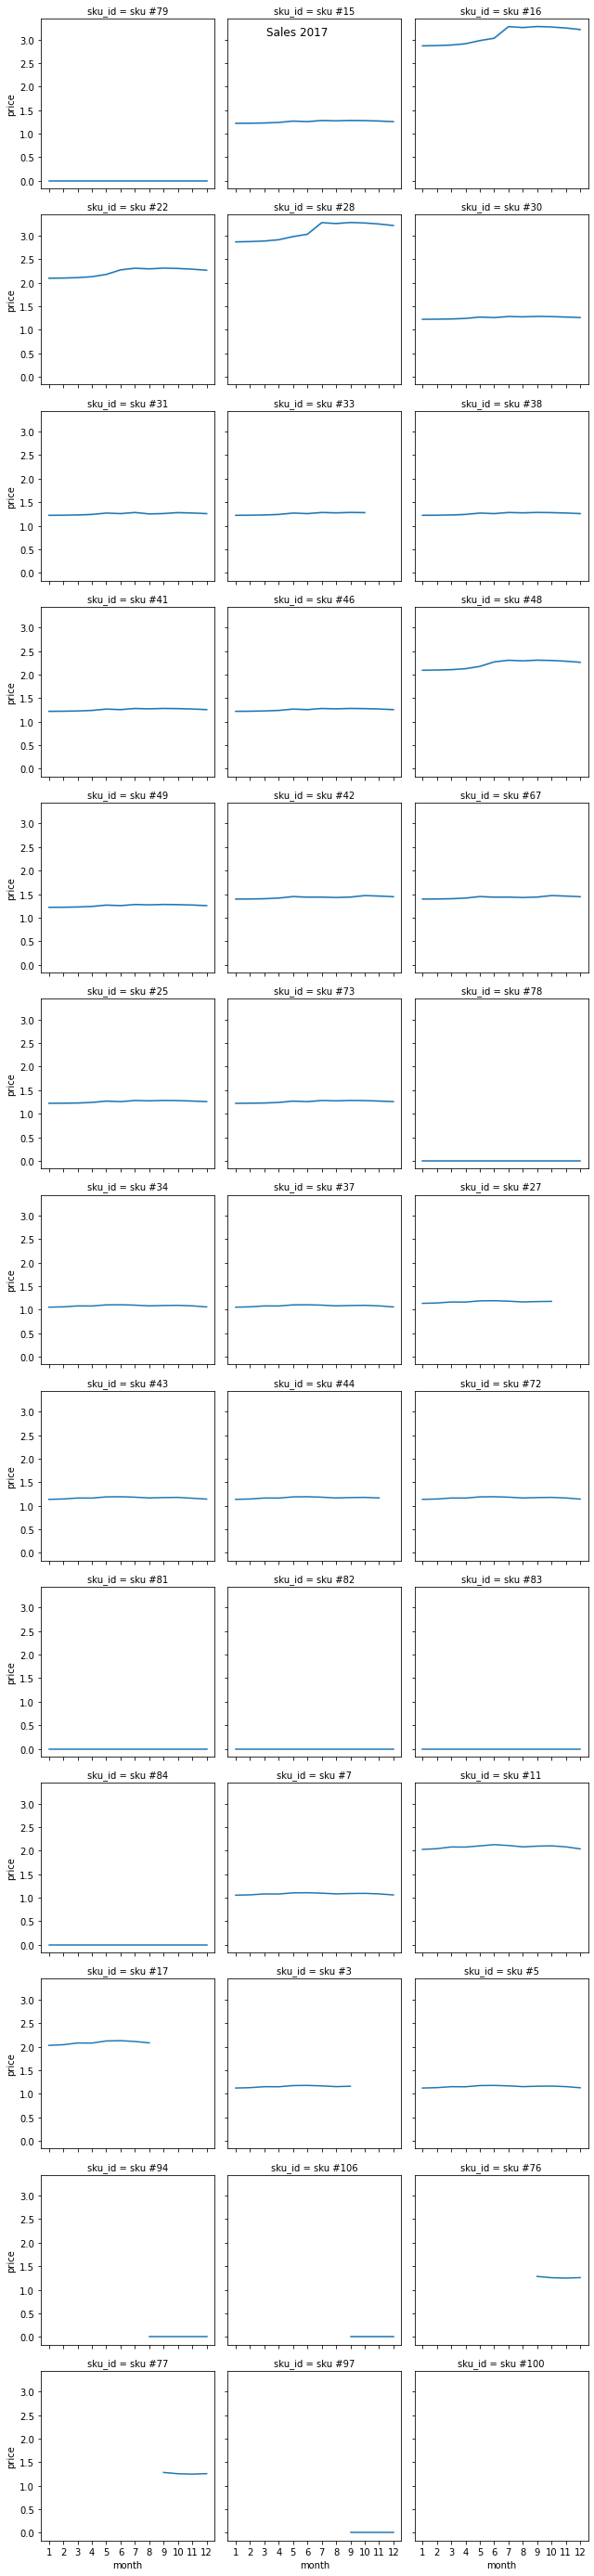

In [56]:
g = sns.FacetGrid(df_s[(df_s['year']==2017)], col="sku_id", col_wrap=3, height=3, margin_titles=True, despine=False)
g.fig.suptitle('Sales 2017')
g.set(xticks=range(1,13))
g.map(sns.lineplot, "month", "price");

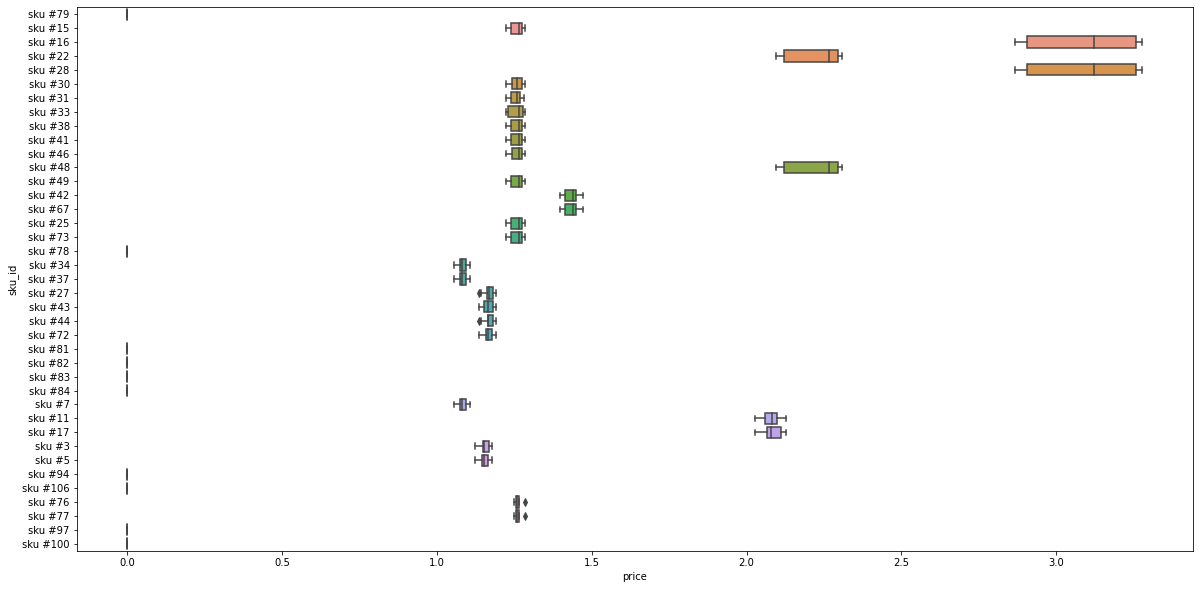

In [21]:
fsize = (20, 10)
fig, ax = plt.subplots(figsize=fsize)
sns.boxplot(data=df_s[(df_s['year']==2017)], y='sku_id', x='price');

Т.к. цена положительаня величина, то если среднее значение равно нулю, то у этого товара за выбранный период только пропуски по цене, выберу их:

In [8]:
df_sku_nan = df_s[(df_s['year']==2017)].groupby(['sku_id']).filter(lambda x: x['price'].mean() == 0.)['sku_id'].value_counts().reset_index()
df_sku_nan

index  sku_id
0   sku #78      24
1   sku #79      24
2   sku #83      12
3   sku #84      12
4   sku #81      12
5   sku #82      12
6  sku #106       8
7   sku #97       4
8   sku #94       3
9  sku #100       1

In [23]:
df_s[df_s['sku_id'].isin(df_sku_nan['index'].values)].groupby(['sku_id'])['volume'].sum()

sku_id
sku #100     66132.0
sku #106     87234.0
sku #78     124620.0
sku #79     282636.0
sku #81     120684.0
sku #82      60744.0
sku #83      77562.0
sku #84      87870.0
sku #94      25686.0
sku #97     166422.0
Name: volume, dtype: float64

Полностью сходится с количеством NaN, значит нет товаров у которых цен нет частично за 2017 год, если NaN, то цен товара нет вообще, т.е. получается, что у этих товаров вообще нет никаких данных по ценам за 2017, при этом есть продажи, значит цену по каким то причинам не указали.

#### Более подробно о продажах

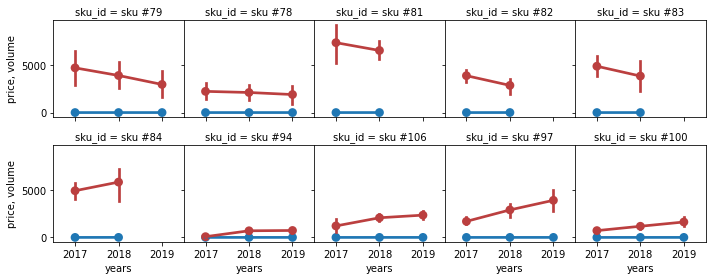

In [45]:
g = sns.FacetGrid(df_s[df_s['sku_id'].isin(df_sku_nan['index'].values)], col="sku_id", col_wrap=5, height=2, margin_titles=True, despine=False)
g.map(sns.pointplot, "year", "price", order=None);
g.map(sns.pointplot, "year", "volume", color="#bb3f3f", order=None);
g.set_axis_labels("years", "price, volume")
g.fig.subplots_adjust(wspace=0)

Красным - продажи  
Синим - цена  


Данные по этим товарам есть за другие года, но есть и такие у кого данные только до 2018 года, т.е. нет ни цен, ни продаж за 2019.  
Т.к. постановка задачи звучит как сделать прогноз продаж на 3 мес с июля 2019, то для корректного предсказания нужны данные до 07.2019, иначе правдоподобность прогноза может быть сомнительной.  

А как обстоят дела с наличием цен и продаж по другим товарами за все года?

In [54]:
%%time
#g = sns.FacetGrid(data=df_s[~df_s['sku_id'].isin(df_sku_nan['index'].values)], col="year", row="sku_id", height=2)#, col_wrap=11, height=2)
#g.map(sns.pointplot, "month", "volume", color="#bb3f3f");

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 12.2 µs


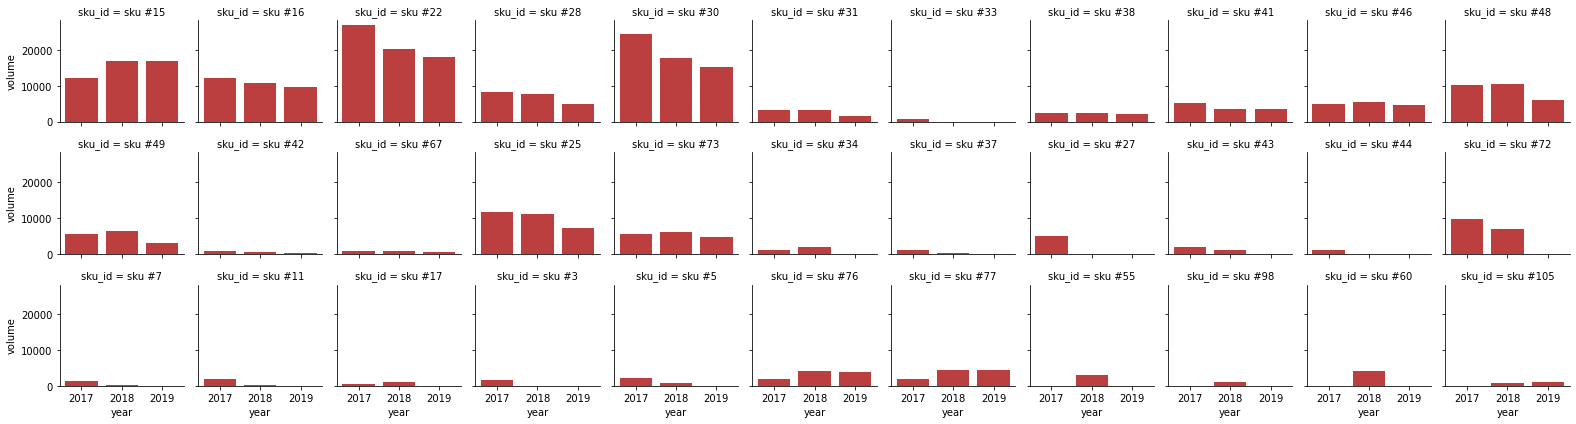

In [52]:
g = sns.FacetGrid(data=df_s[~df_s['sku_id'].isin(df_sku_nan['index'].values)], col="sku_id", col_wrap=11, height=2)
g.map(plt.bar, "year", "volume", color="#bb3f3f");

Тоже существуют товары у которых нет данных по продажам за 2019 год.

#### Динамика продаж товаров за полный период

In [9]:
#Создам новый столбец с датой
df_s['date'] = df_s[['year','month']].apply(lambda r: '{}-{}'.format(r['year'], r['month']), axis=1)
df_s['date'] = pd.to_datetime(df_s['date'])

In [10]:
sns.color_palette("Set2", len(df_s['ira'].unique()))

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)]

In [11]:
#палитра цветов для городов
colors_ira = dict(zip(df_s['location'].unique(), sns.color_palette("Set2", len(df_s['ira'].unique()))))

/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


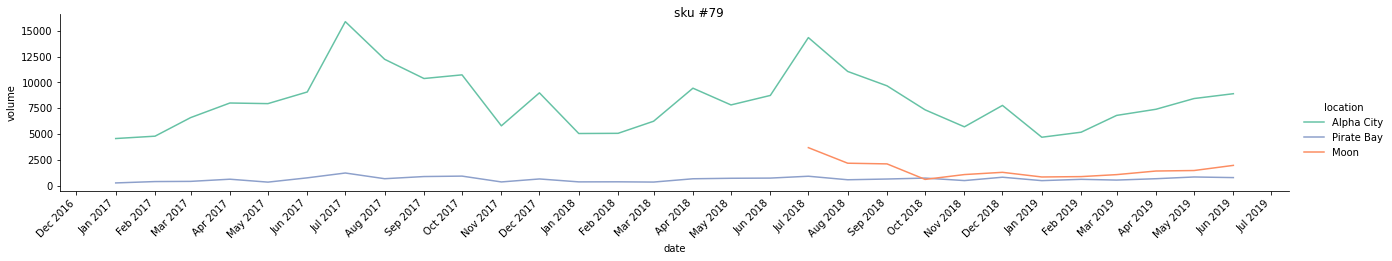

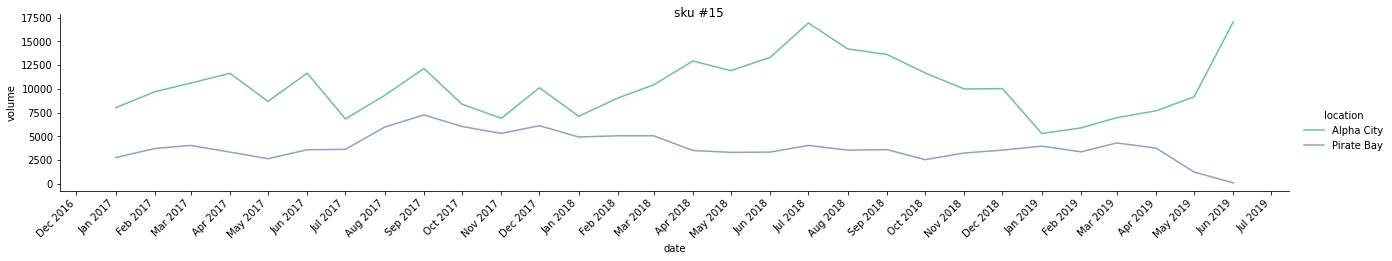

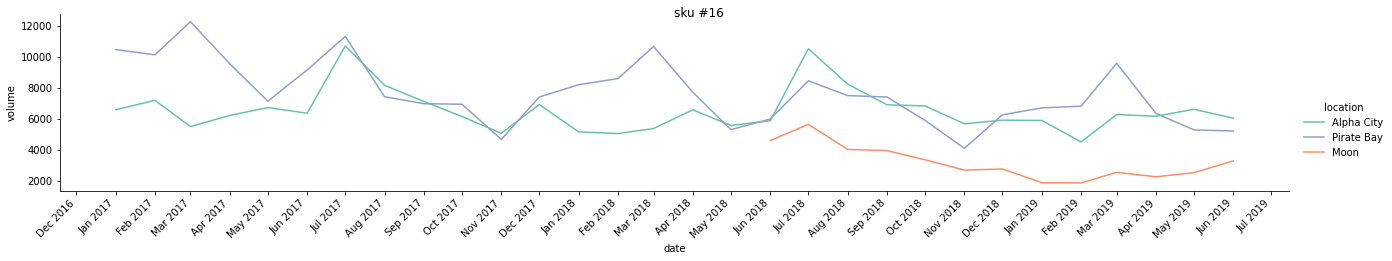

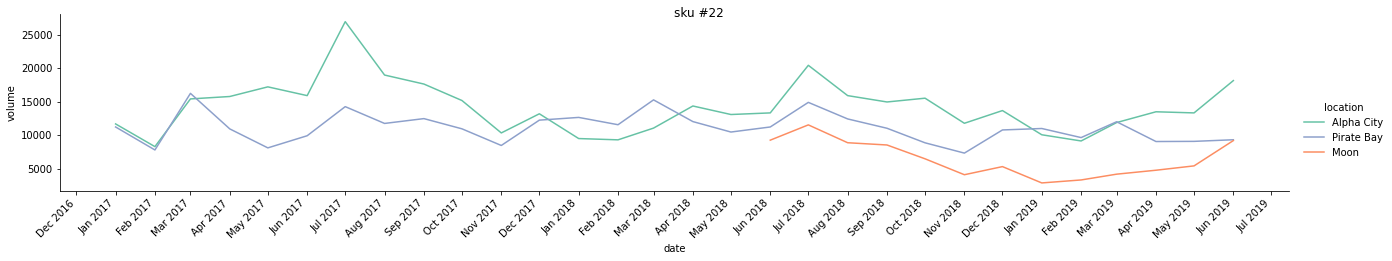

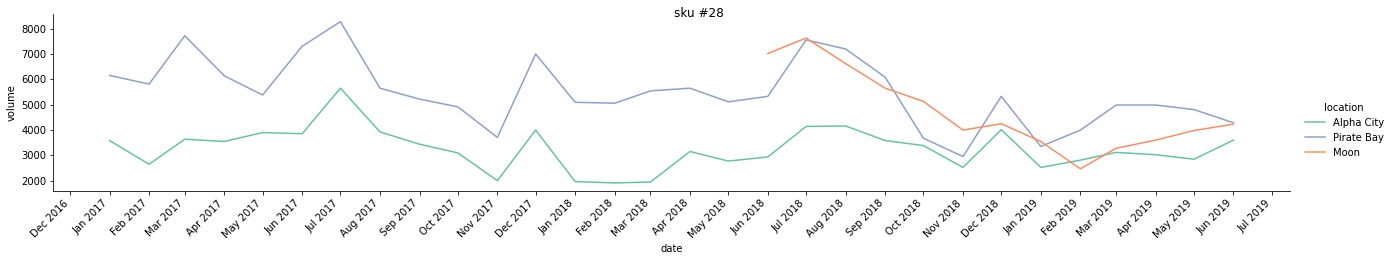

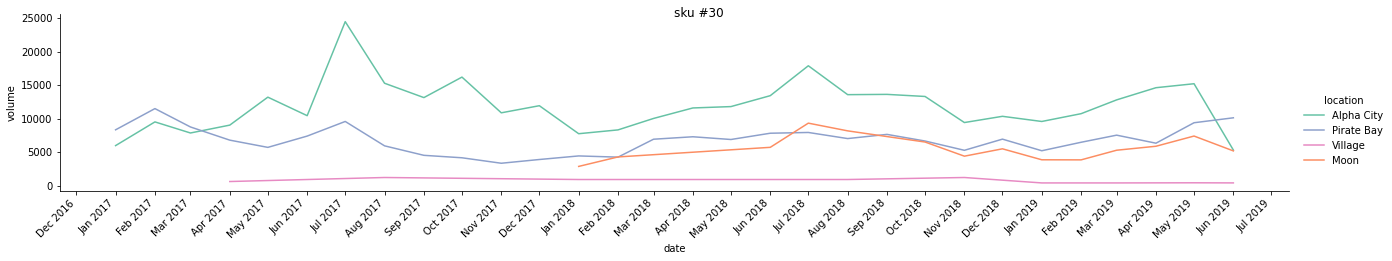

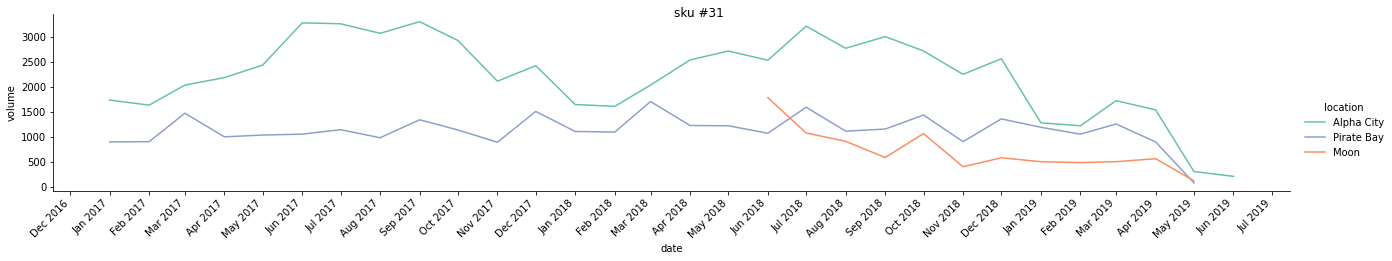

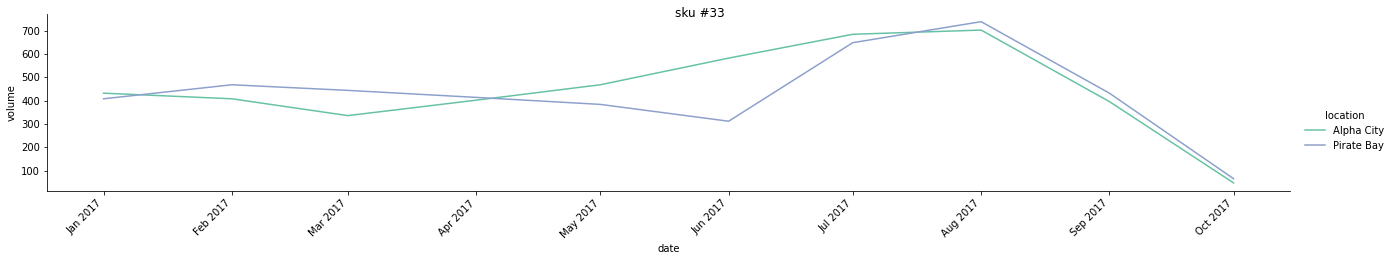

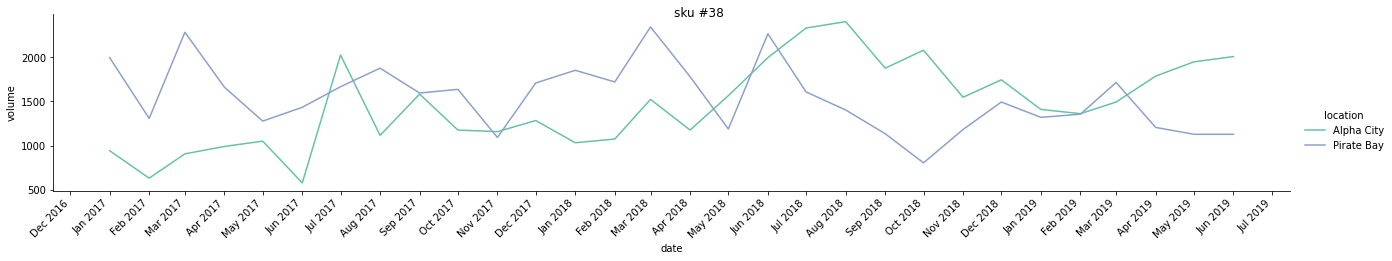

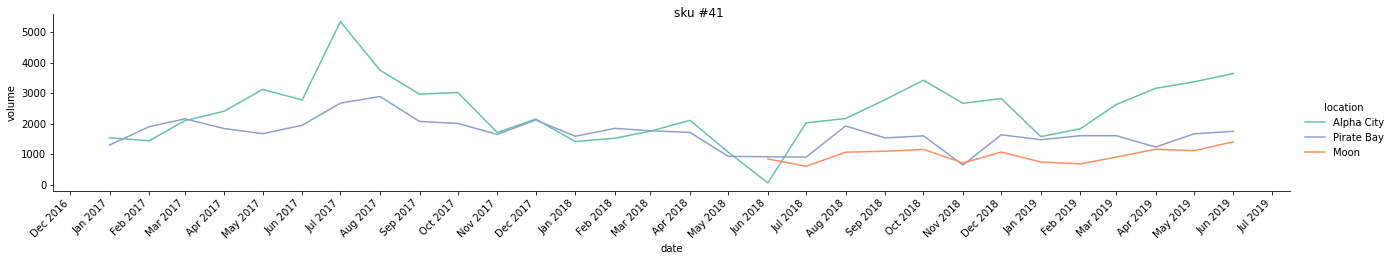

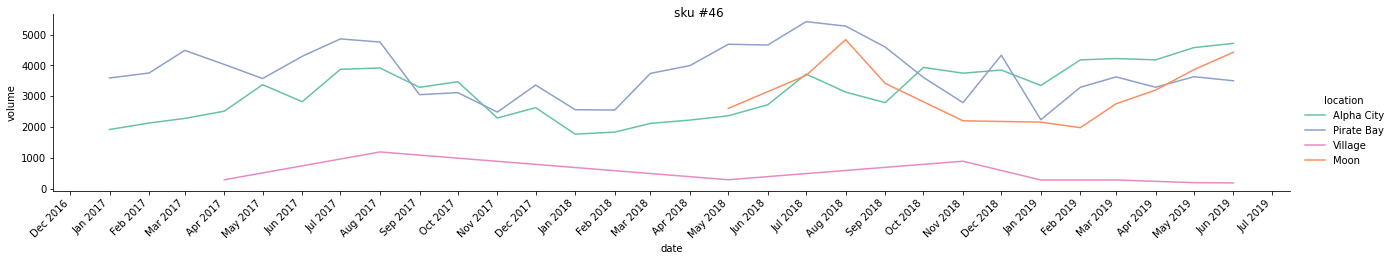

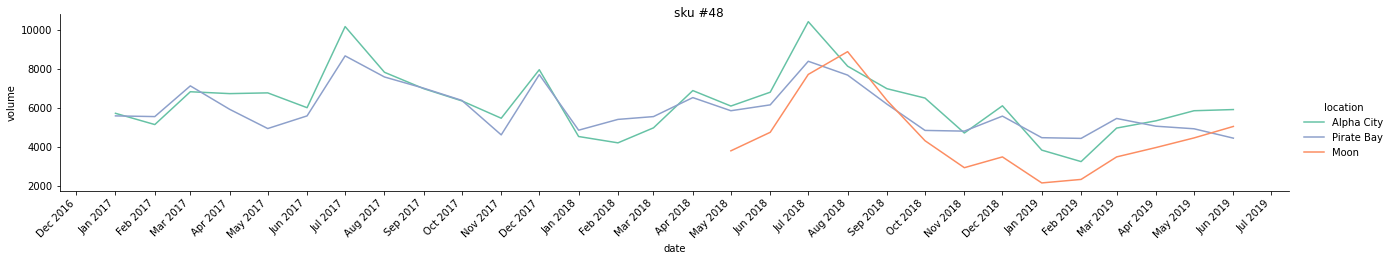

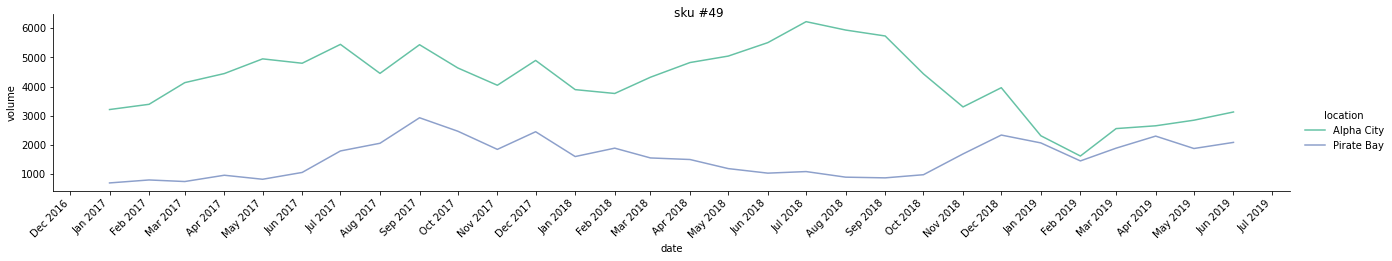

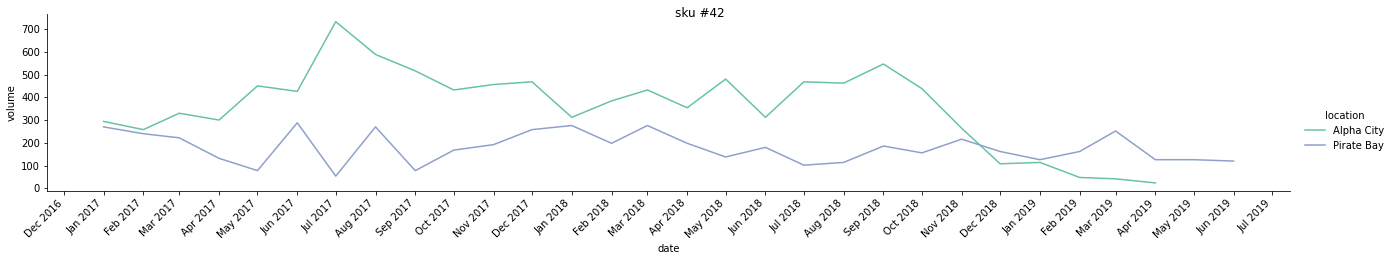

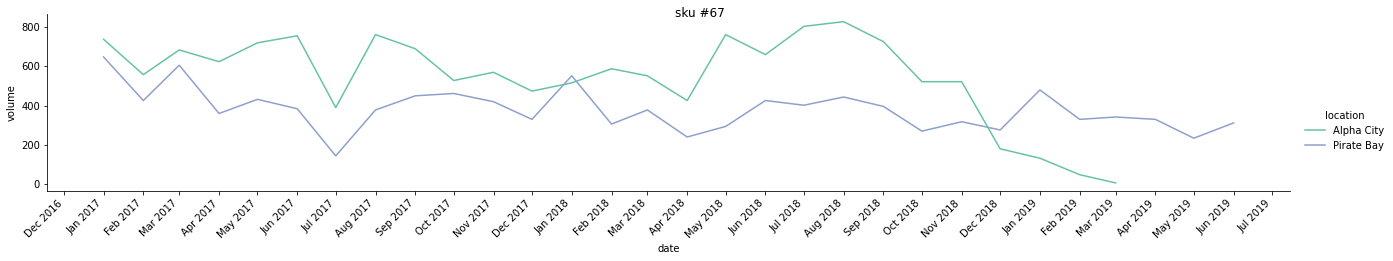

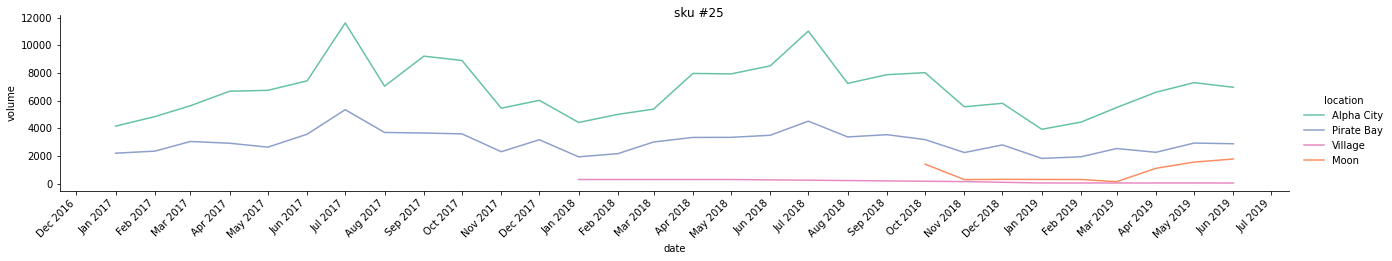

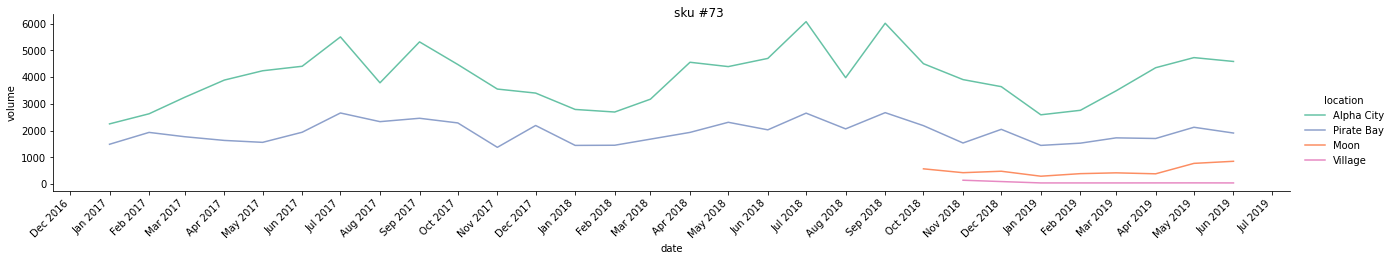

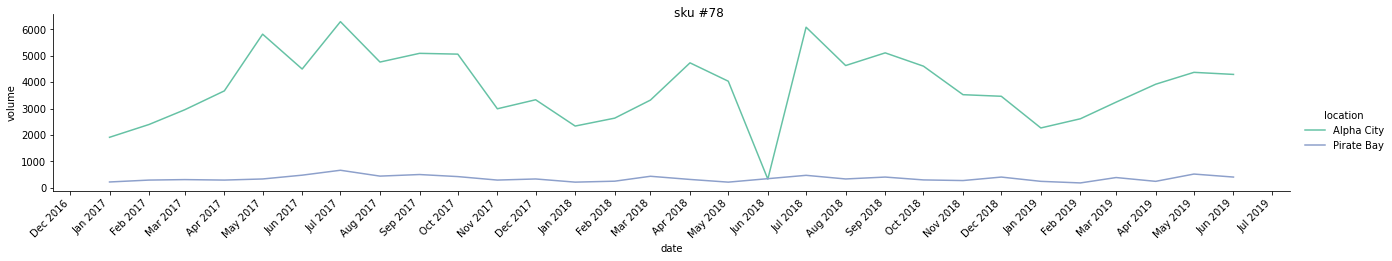

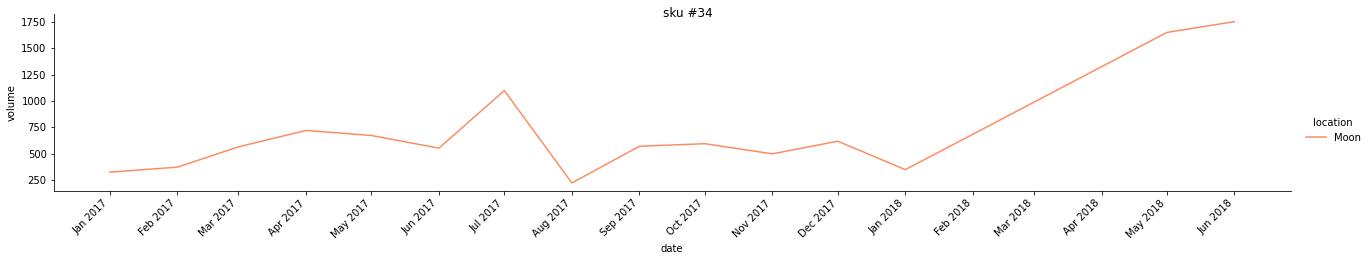

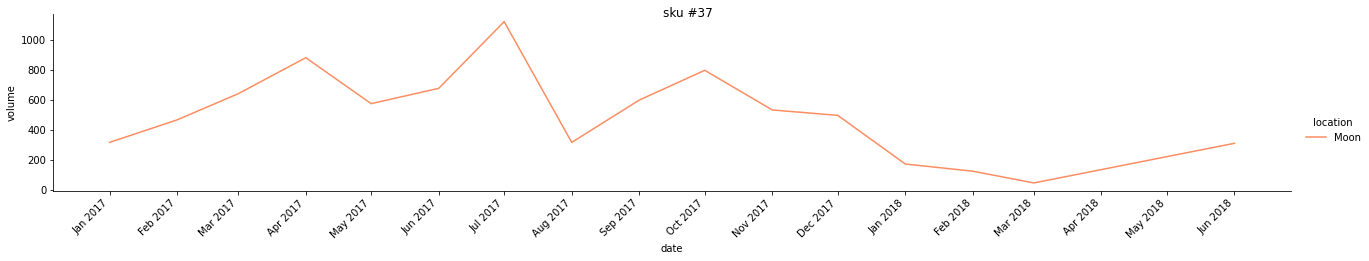

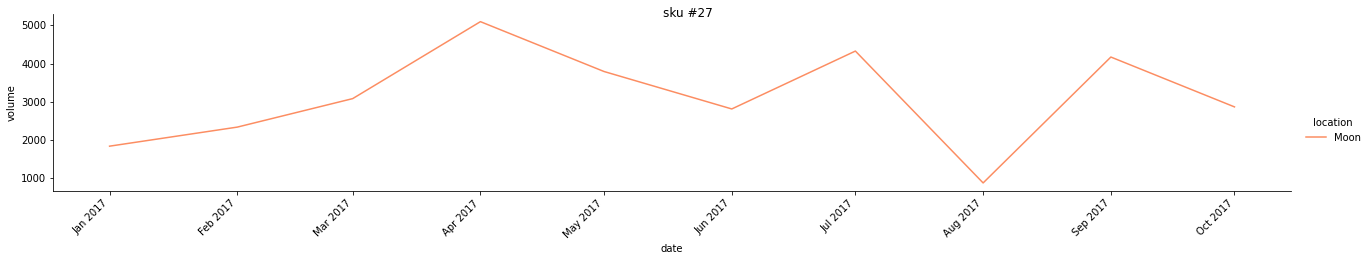

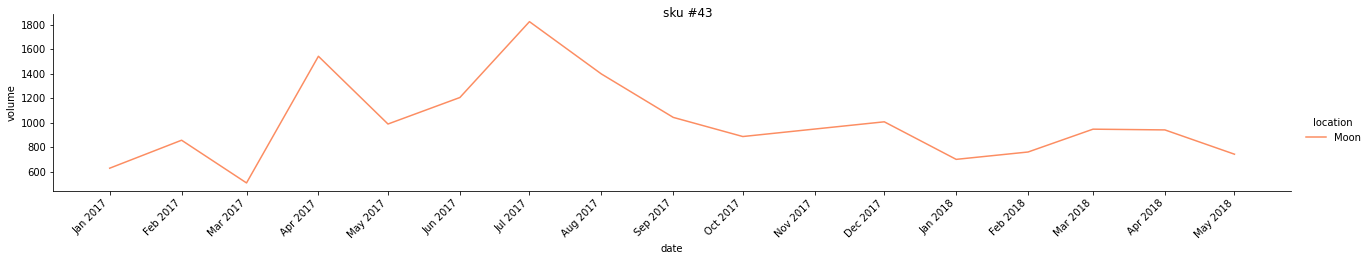

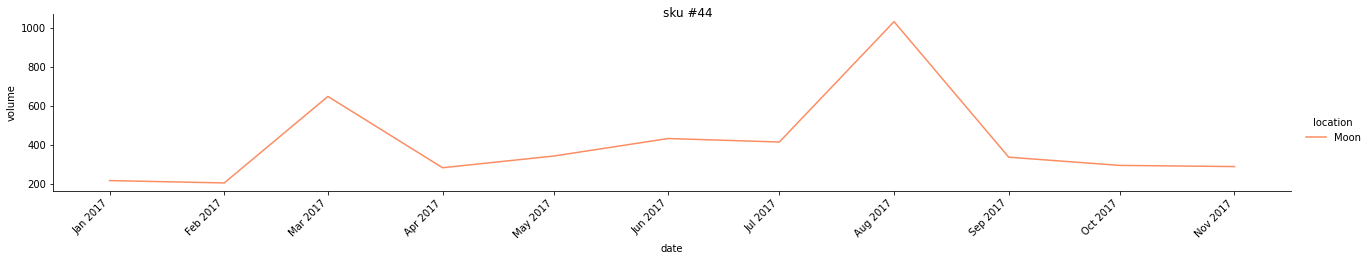

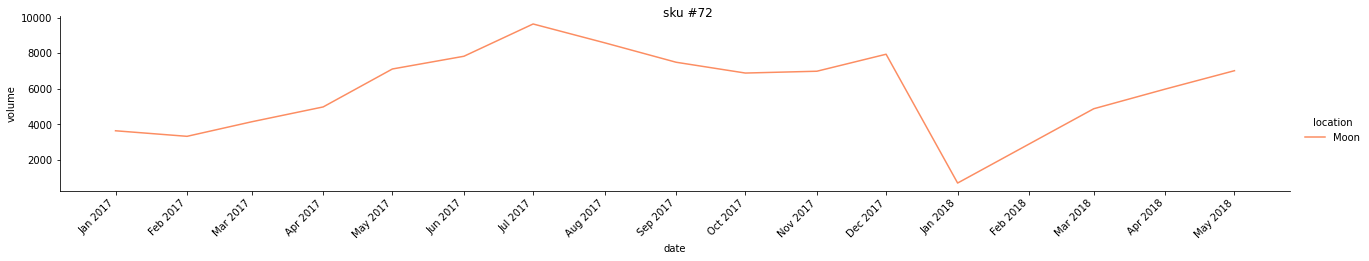

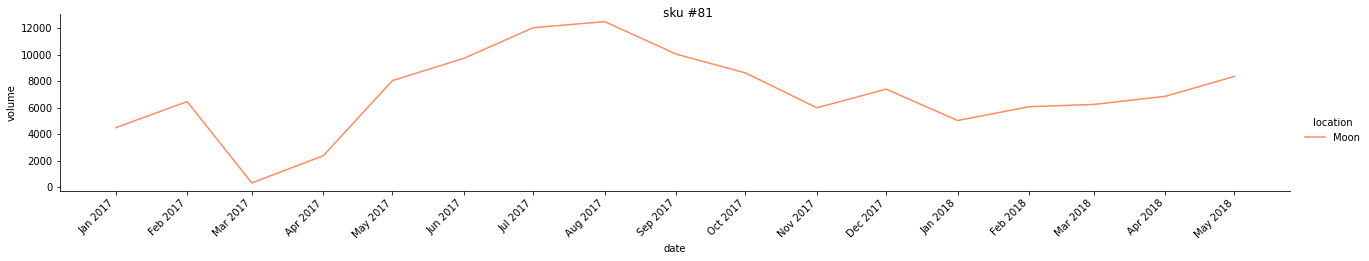

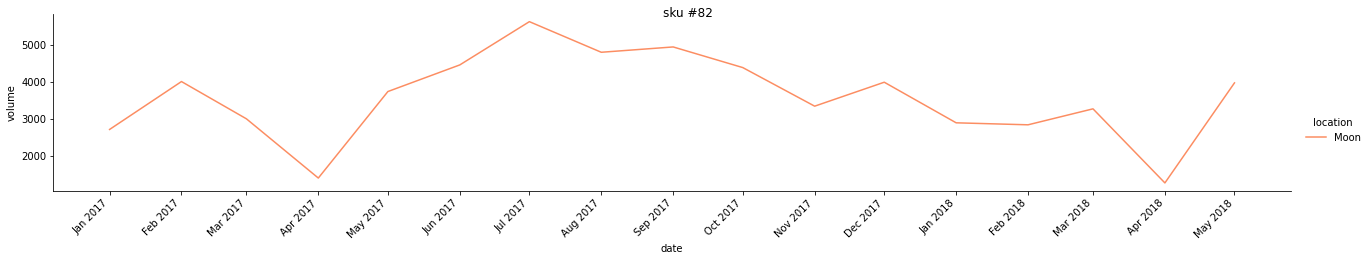

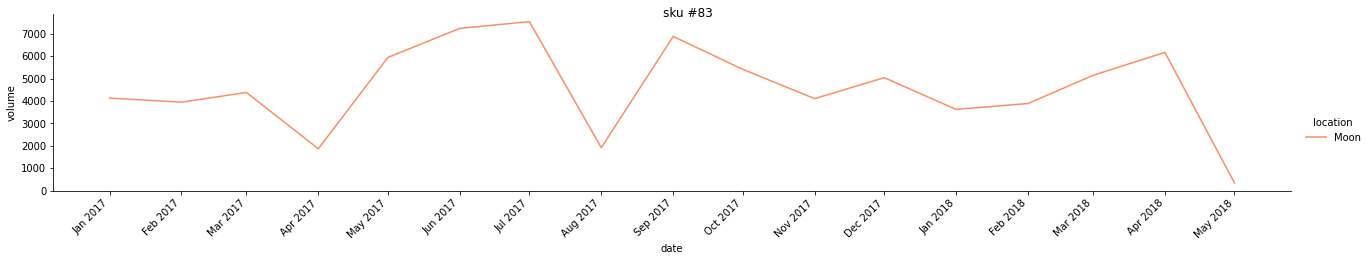

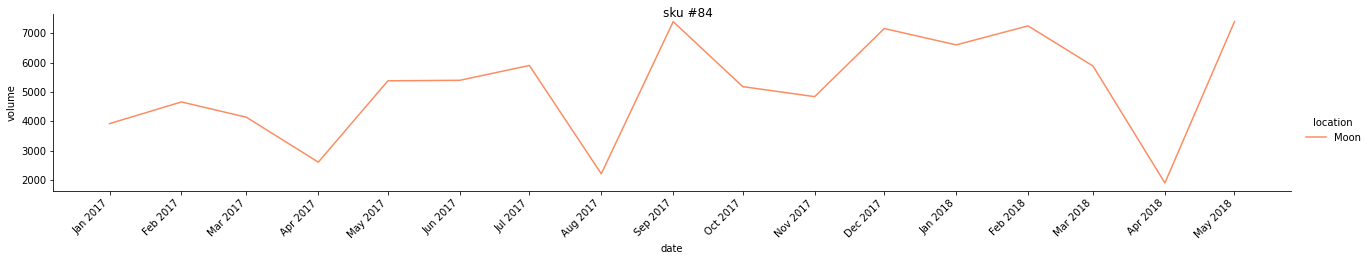

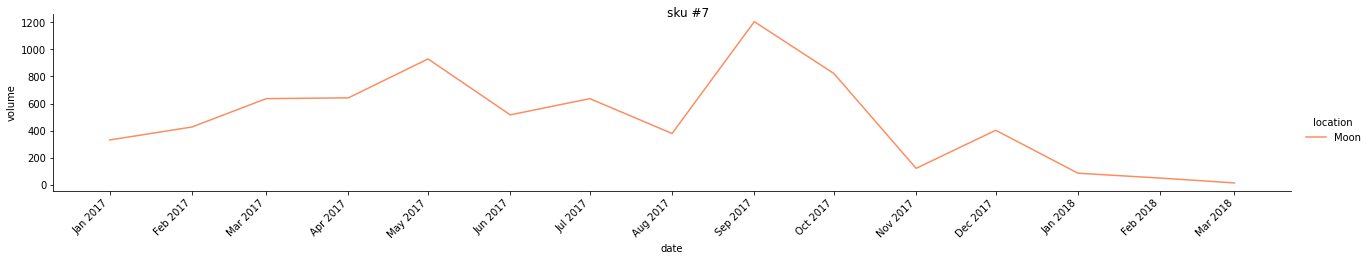

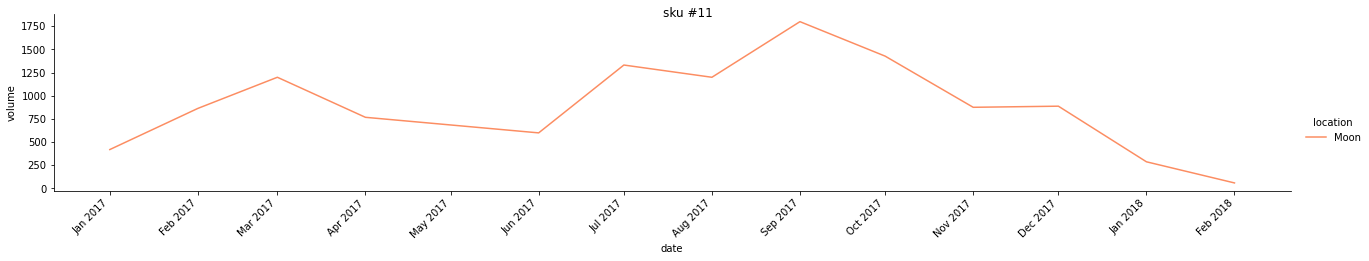

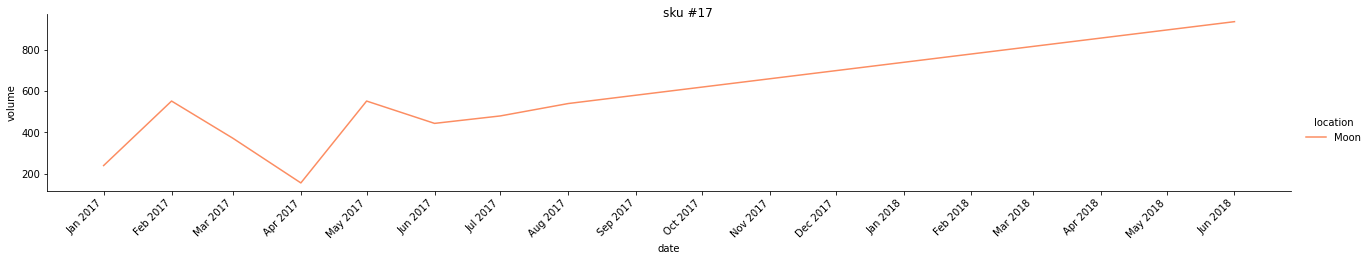

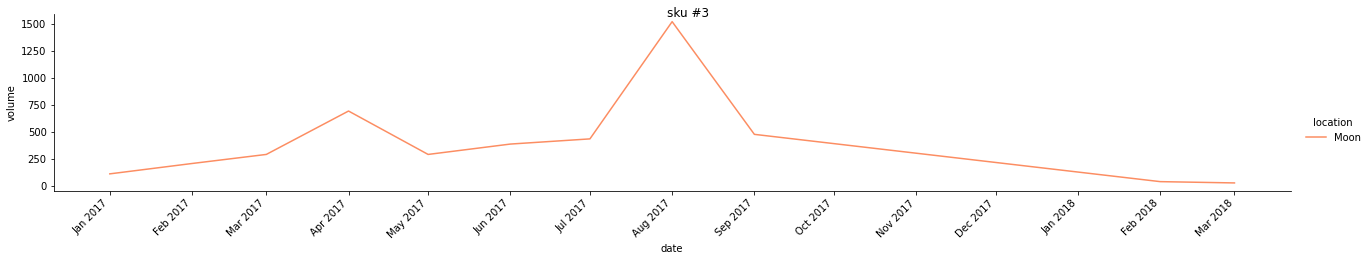

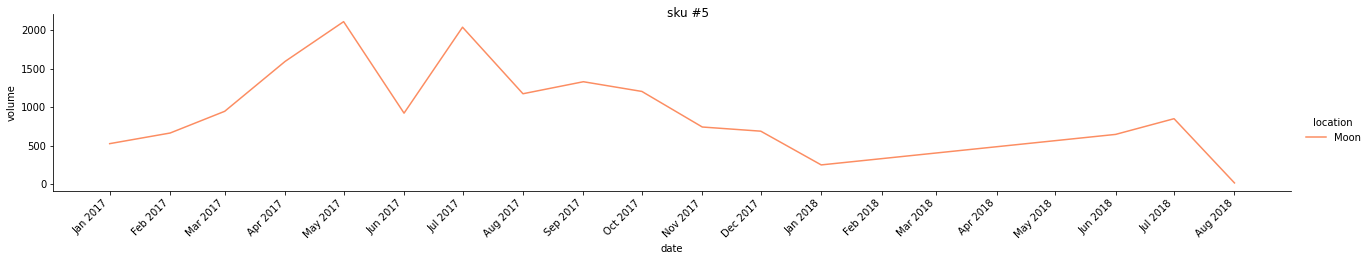

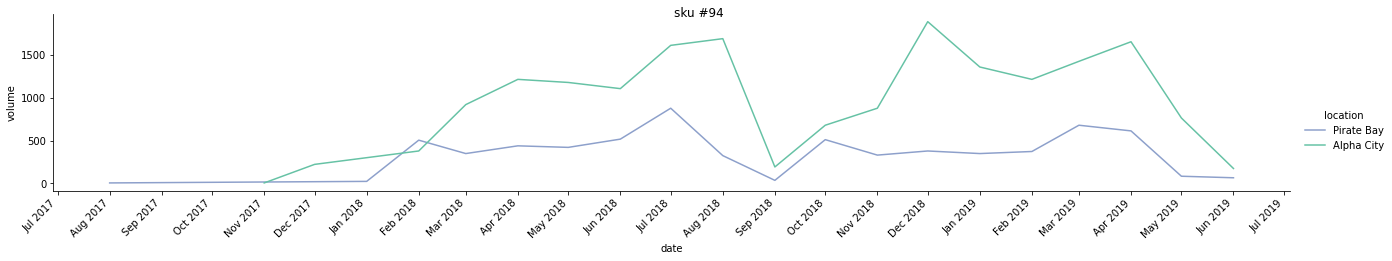

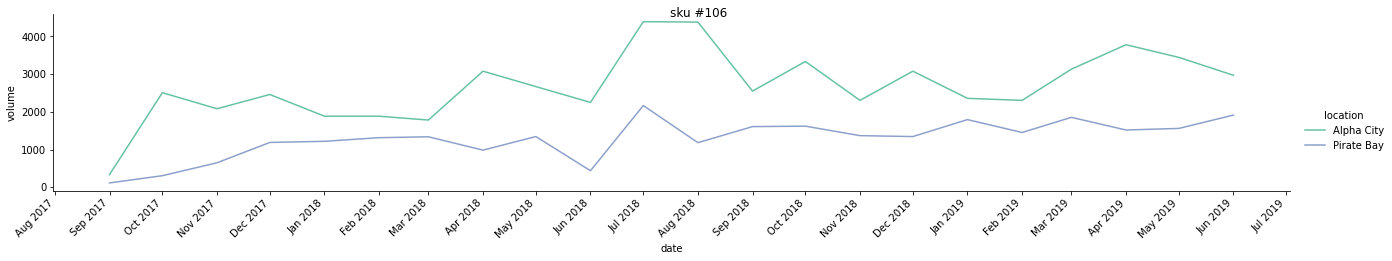

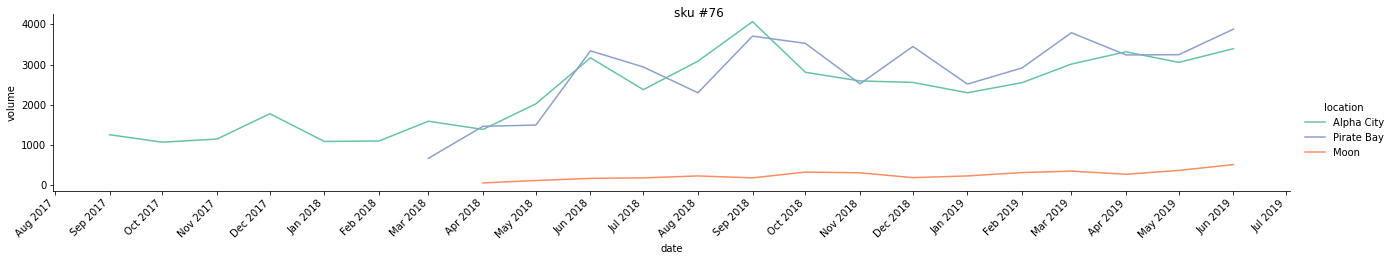

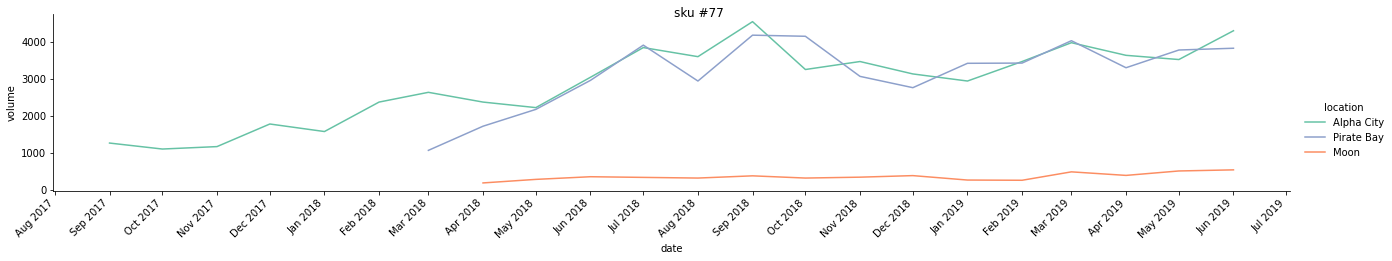

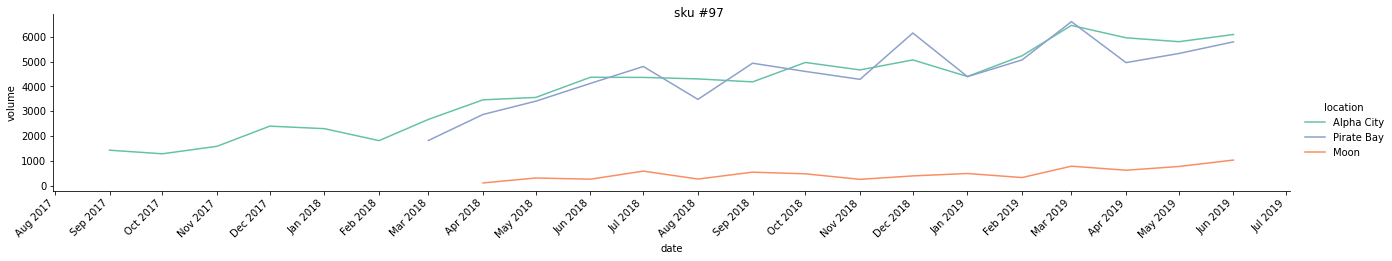

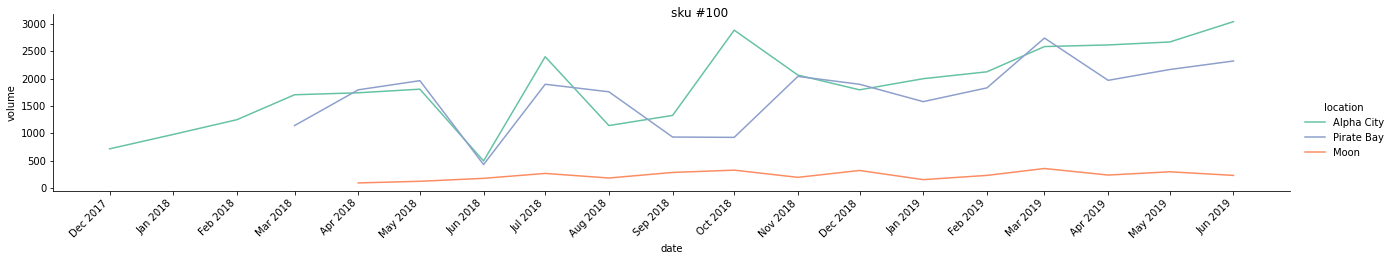

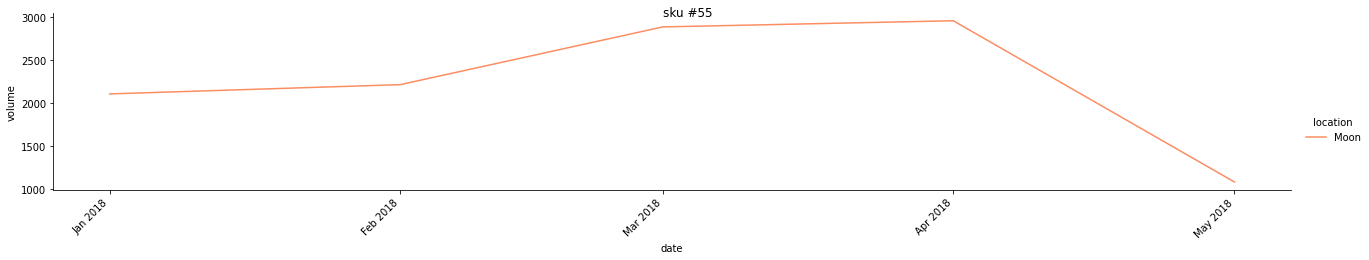

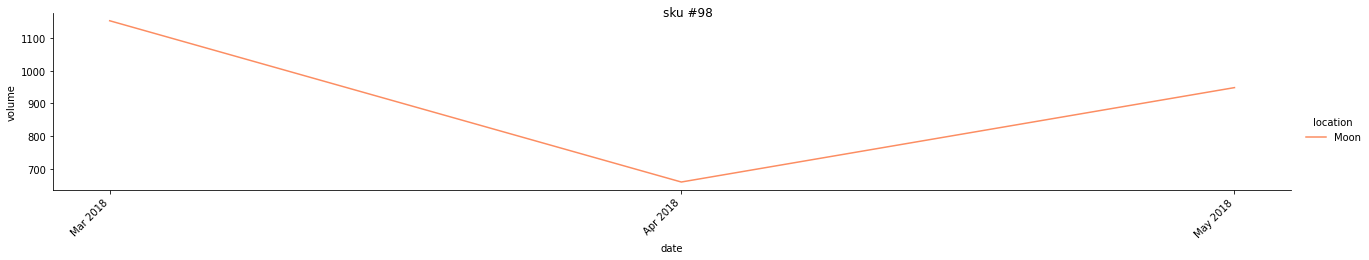

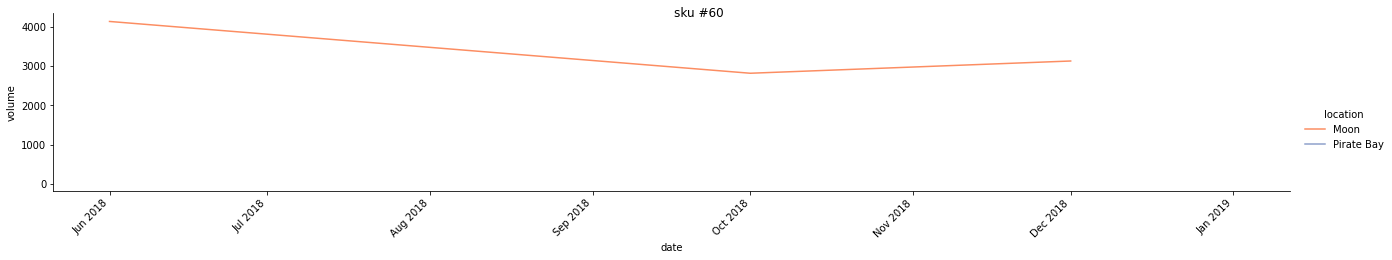

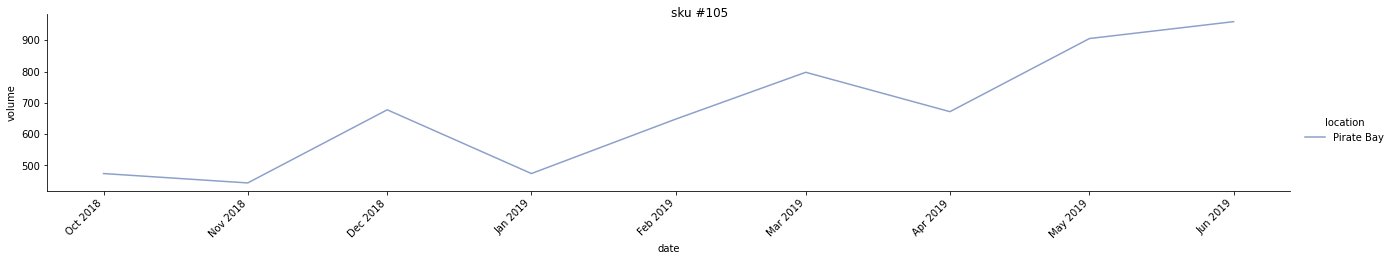

In [78]:
for sku in df_s['sku_id'].unique():
    data=df_s[df_s['sku_id']==sku]
    g=sns.relplot(
        data=data,
        x="date", y="volume",
        hue="location", 
        kind="line", palette=colors_ira,
        height=3, aspect=6, facet_kws=dict(sharex=False),
    )
    g.ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=1))
    g.ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(g.ax.get_xticklabels(), rotation=45, ha="right")
    g.fig.suptitle(sku);

Какие наблюдения можно сделать:  
 - некоторые товары продаются только в определенных городах всегда
 - некоторые товары продавались только в определенных городах до определенного периода, затем перестали продавать вообще
 - часть товаров не поступало в часть городов до определенного момента или перестало поступать после
 - по части товаров данные по продаже есть не за каждый месяц, а например по квартально
 - есть товары, у которых слишком маленькая история продаж в определенных городах, т.е. продаются там относительно недавно 
 - по нескольким товарам много пиков продаж в июле, видимо связано с отпусками, но есть и товары у которых в июле есть провалы в продажах
 - есть товары, которые стабильно продавались, но затем продажи упали и они вовсе исчезли из оборота
 - есть товары у которых продажи падали до минимума а затем восстановились до пиков
 - есть товары по которым долгое время не было данных по продаже и затем появились

#### Продажи все товаров внутри города

In [12]:
sns.color_palette("turbo_r", len(df_s['sku_id'].unique()))

[(0.54583, 0.03593, 0.00638),
 (0.61923, 0.06367, 0.0041),
 (0.68602, 0.09536, 0.00481),
 (0.74617, 0.13098, 0.00851),
 (0.79971, 0.17055, 0.0152),
 (0.83926, 0.20654, 0.02305),
 (0.88066, 0.25334, 0.03521),
 (0.91572, 0.3053, 0.05134),
 (0.94538, 0.36638, 0.07461),
 (0.96904, 0.43399, 0.10294),
 (0.9859, 0.50479, 0.13367),
 (0.99419, 0.56386, 0.15918),
 (0.99654, 0.63193, 0.18738),
 (0.98986, 0.69382, 0.21043),
 (0.97323, 0.74682, 0.22536),
 (0.94489, 0.79634, 0.228),
 (0.91317, 0.83576, 0.22328),
 (0.86709, 0.87968, 0.21391),
 (0.8141, 0.91861, 0.20552),
 (0.75617, 0.95121, 0.20343),
 (0.69525, 0.9761, 0.21294),
 (0.63323, 0.99195, 0.23937),
 (0.57357, 0.99817, 0.27712),
 (0.48879, 0.99828, 0.33816),
 (0.39678, 0.99098, 0.41098),
 (0.30513, 0.97697, 0.48987),
 (0.22142, 0.95692, 0.56914),
 (0.16319, 0.93609, 0.63137),
 (0.11374, 0.90673, 0.69651),
 (0.0932, 0.87211, 0.75237),
 (0.10026, 0.82955, 0.81389),
 (0.12698, 0.78037, 0.8759),
 (0.16529, 0.7262, 0.93161),
 (0.20021, 0.67842, 0.96833),
 (0.23874, 0.61931, 0.99485),
 (0.26592, 0.55979, 0.99583),
 (0.27543, 0.50115, 0.96594),
 (0.27691, 0.44145, 0.91328),
 (0.27429, 0.39043, 0.85393),
 (0.26652, 0.32768, 0.76412),
 (0.25369, 0.26327, 0.65406),
 (0.23582, 0.1972, 0.52373),
 (0.21291, 0.12947, 0.37314)]

In [13]:
colors_sku = dict(zip(df_s['sku_id'].unique(), sns.color_palette("turbo_r", len(df_s['sku_id'].unique()))))

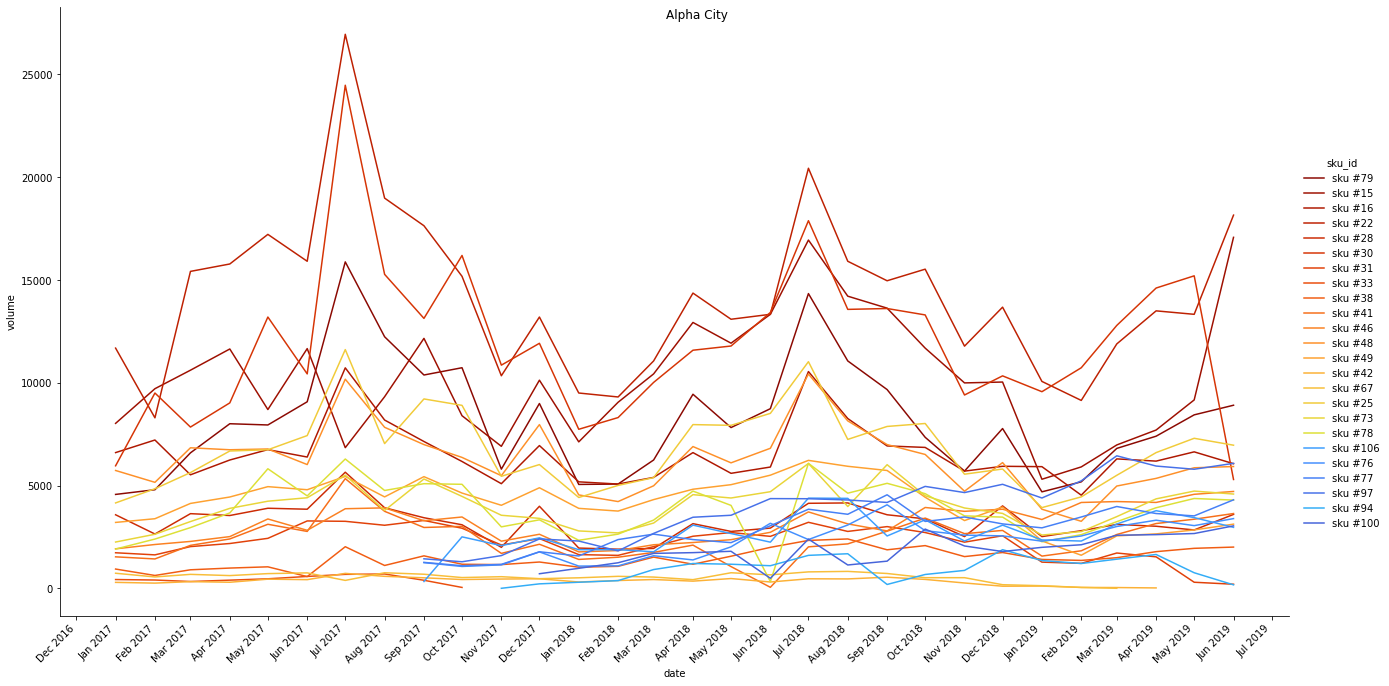

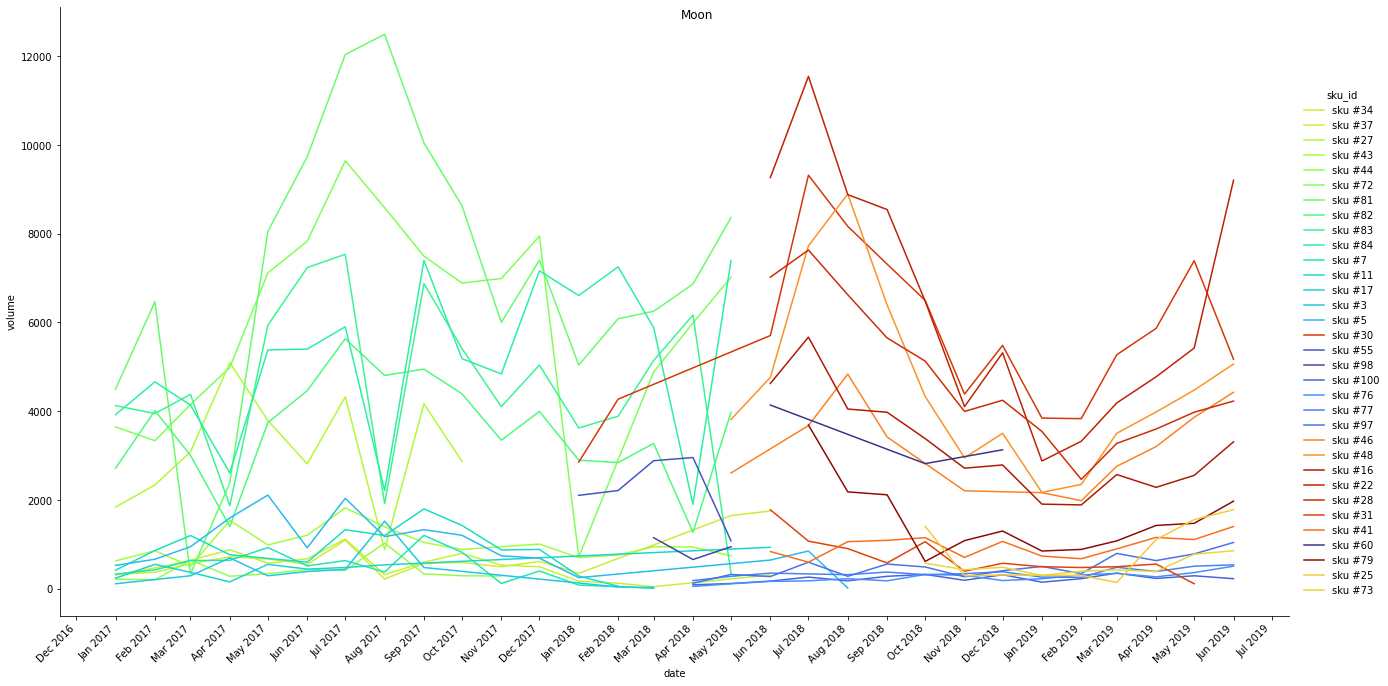

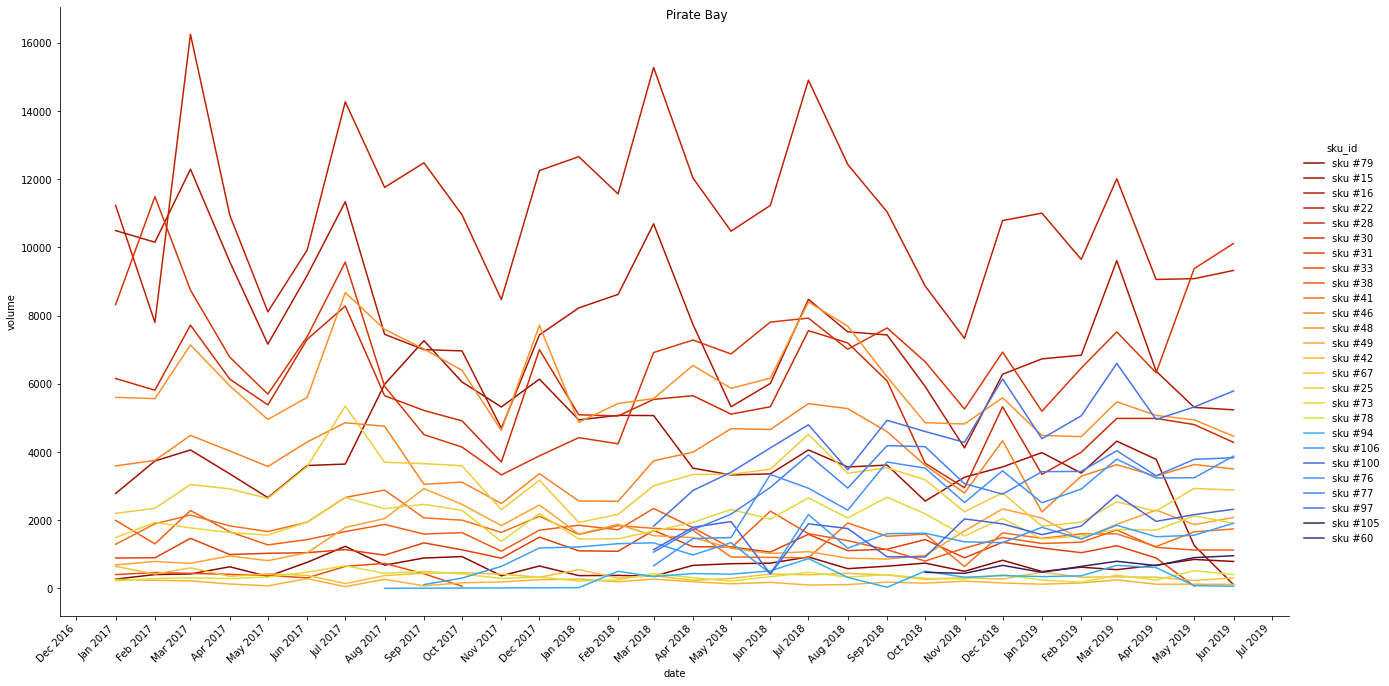

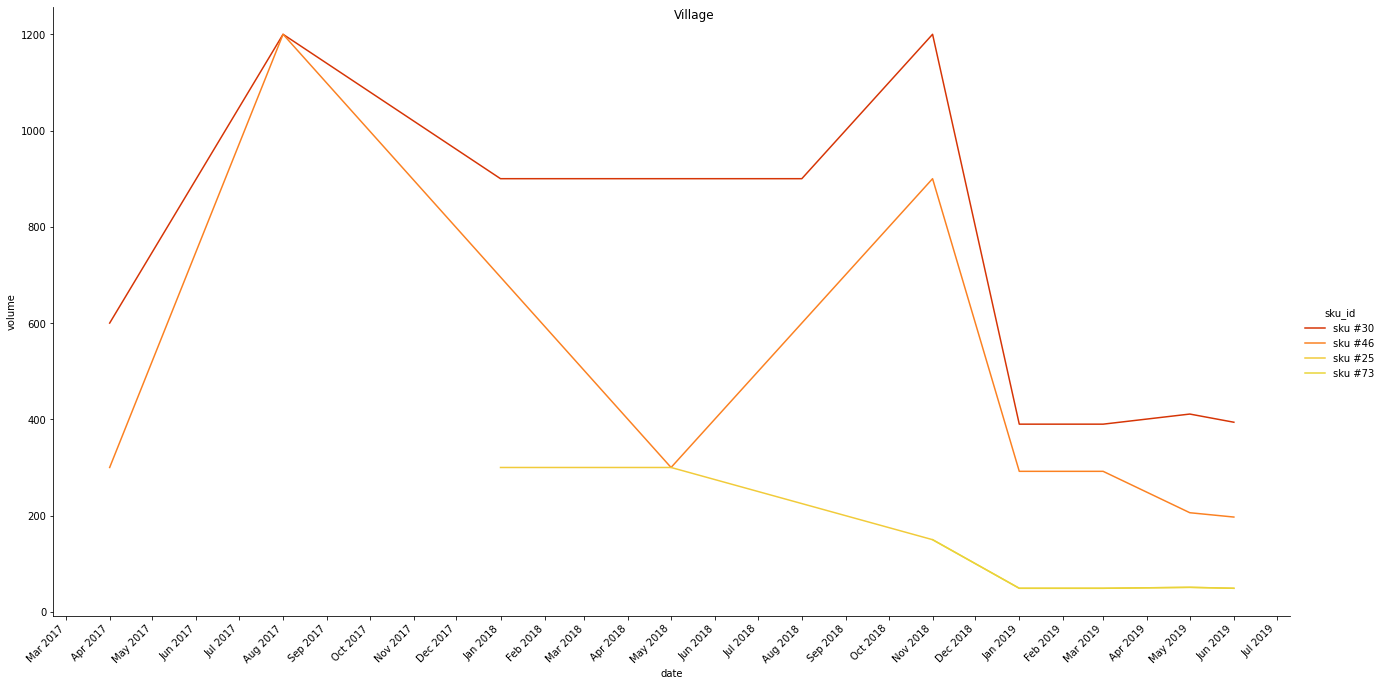

In [82]:
for loc in df_s['location'].unique():
    data=df_s[df_s['location']==loc]
    g=sns.relplot(
        data=data,
        x="date", y="volume",
        hue="sku_id", 
        kind="line", palette=colors_sku,
        height=9, aspect=2, facet_kws=dict(sharex=False),
    )
    g.ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=1))
    g.ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(g.ax.get_xticklabels(), rotation=45, ha="right")
    g.fig.suptitle(loc);

Какие наблюдения можно сделать:
 - не все товары которые продаются в конкретном городе продавались там всегда, какие то появлялись позже, какие то переставали продаваться
 - например в городе "Moon" сначала продавались одни товары (причем эти товары продавались только тут), затем, был полностью изменен ассортимент на другие товары
 - какие то товары в одних городах начали продаваться раньше чем в других
 - по многим товарам пики продаж совпадают
 - по "Village", продается всего 4 товара, данные по продажам есть раз в несколько месяцев, видимо название говорит само за себя, в деревне спрос не большой и нет необходимости в большом ассортименте и поставкам товаров каждый месяц и с ноября 2018 все продажи резко упали

#### Какие товары продаются лучше?

Средние продажи всех товаров за весь период:

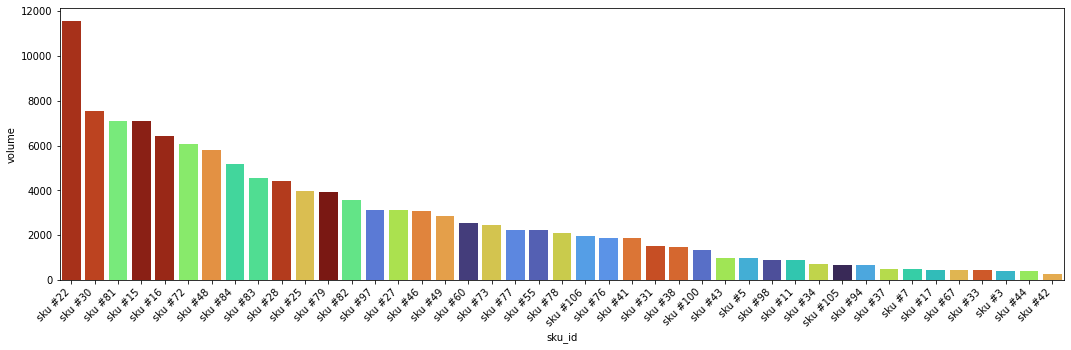

In [198]:
fsize = (18, 5)
fig, ax = plt.subplots(figsize=fsize)
data = df_s.groupby('sku_id')['volume'].mean().reset_index().sort_values('volume', ascending=False)
sns.barplot(data=data, x='sku_id', y='volume', palette=colors_sku);
plt.setp(ax.get_xticklabels(), rotation=45, ha="right");

По годам:

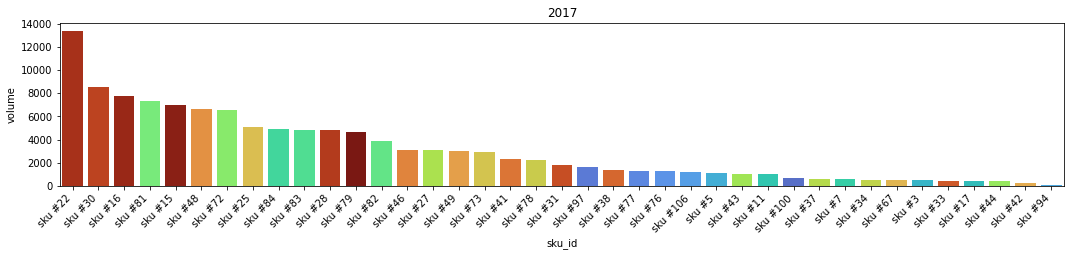

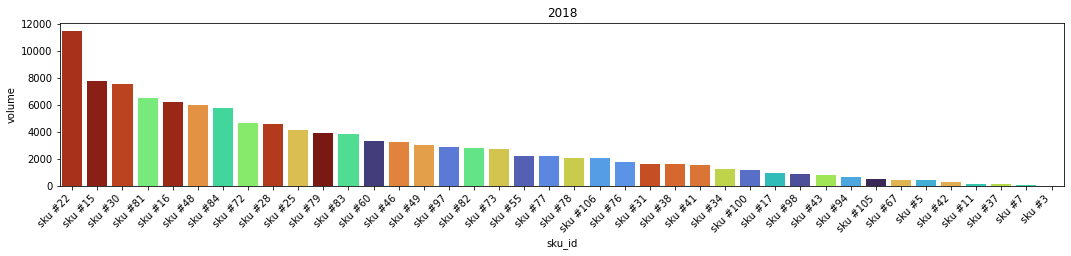

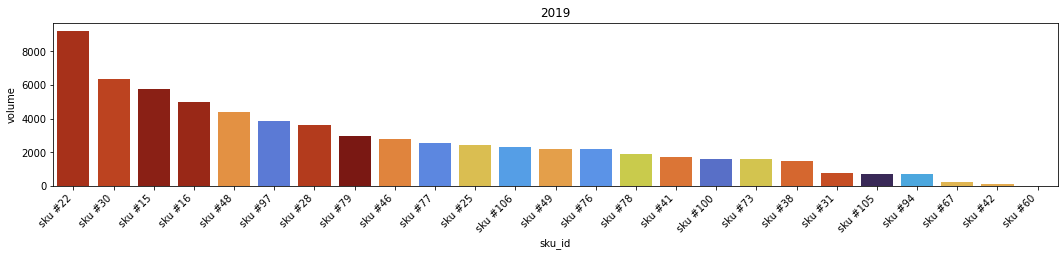

In [160]:
for year in df_s['year'].unique():
    fsize = (18, 3)
    fig, ax = plt.subplots(figsize=fsize)
    data = df_s[df_s['year']==year].groupby('sku_id')['volume'].mean().reset_index().sort_values('volume', ascending=False)
    plt.title(year)
    sns.barplot(data=data, x='sku_id', y='volume', palette=colors_sku);
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right");

Если в 2017 и 2018 годах топ 10 товаров по продажам был примерно одинаковый, то в 2019 году топ изменился, часть товаров вообще исчезла из продаж, например 'sku #81', 'sku #84' да и в целом "зеленые" товары.

Посмотрим на средние продажи топ 10 товаров в каждом городе:

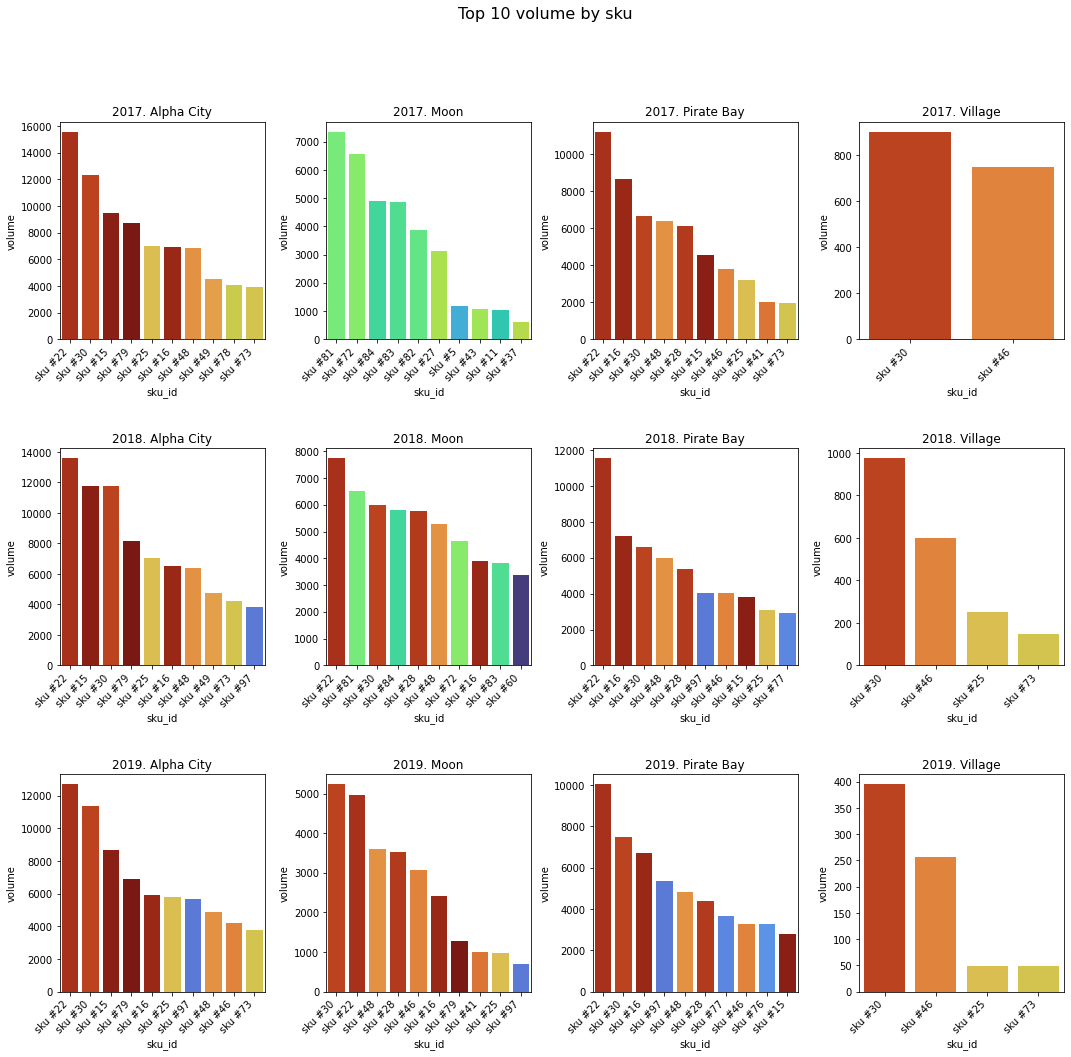

In [197]:
data = df_s.groupby(['sku_id','year','location'])['volume'].mean().reset_index()
years = data['year'].unique()
locations = data['location'].unique()

fig, axes = plt.subplots(nrows=len(years), ncols=len(locations), figsize=(18, 16))
fig.suptitle('Top {} volume by sku'.format(top_sku_volume), fontsize=16)

top_sku_volume = 10

for row, row_axes in enumerate(axes):
    year = years[row]
    data_row = data[data['year'] == year]
    i=0
    for column, ax in enumerate(row_axes):
        location = locations[i]
        top_in_loc = data_row[data_row['location'] == location].sort_values('volume', ascending=False).head(top_sku_volume)
        sns.barplot(data=top_in_loc, x='sku_id', y='volume', palette=colors_sku, ax=ax);
        ax.set_title('{}. {}'.format(year, location))
        i+=1
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.subplots_adjust(hspace=0.5, wspace=0.3)


Интересно как в Moon менялся ассортимент, сначала все "зеленые" товары были на половину заменены на "коричневые" а затем вовсе ушли.  
А в Viliage ассортимент увеличился в 2 раза! :)

In [117]:
data = df_s.groupby(['sku_id','location'])['volume'].mean().reset_index().pivot_table('volume', 'sku_id', 'location')
data.fillna(0, inplace=True)
data = data.nlargest(10, df_s['location'].unique())

In [136]:
data

location    Alpha City         Moon  Pirate Bay     Village
sku_id                                                     
sku #22   14189.366667  6456.000000     11106.4    0.000000
sku #30   11900.866667  5692.400000      6792.4  714.583333
sku #15   10253.600000     0.000000      3914.0    0.000000
sku #79    8159.400000  1558.000000       638.6    0.000000
sku #25    6776.400000   864.000000      2997.0  124.625000
sku #16    6556.200000  3210.923077      7674.6    0.000000
sku #48    6262.866667  4566.857143      5925.2    0.000000
sku #49    4196.600000     0.000000      1558.8    0.000000
sku #73    3992.266667   516.000000      1941.4   66.166667
sku #97    3926.181818   496.400000      4537.5    0.000000

#### Посмотрим на остальные характеристики товара и их влияние на продажи

Для начала нужно понять у товаров с уникальными ИД (sku_id) уникальные характеристики или например есть товары с одинаковым ИД но один содержит алкоголь а другой нет.

In [308]:
df_s_pivot = pd.pivot_table(df_s, values=['volume'], index=['sku_id'], columns=['filling','shape','with_alcohol','item_per_bundle','brand'],
                aggfunc={'volume':'count'}
                )
df_s_pivot.count(axis=1).values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Т.к. все единицы, то уникальные товары имеют уникальные характеристики.

С какими характеристиками товаров продается больше и какие средние продажи:

In [317]:
df_s_pivot = pd.pivot_table(df_s, values=['sku_id', 'volume'], index=[ 'product_category','brand', 'with_alcohol','item_per_bundle'], 
                columns=['filling','shape'], aggfunc={'sku_id':'count', 'volume':'mean'} ,fill_value=0
                ).round(1)
df_s_pivot

sku_id          \
filling                                                      Berries Nothing   
shape                                                         Square  Square   
product_category brand          with_alcohol item_per_bundle                   
Chocolates       Cadbury        No           1                     0       0   
                 Ferrero Rocher No           1                     9      74   
                                             2                     0       0   
                                             3                     0       0   
                                Yes          1                     0       0   
                 Milka          No           1                     0       0   
                 Snickers       No           1                     0       0   
                 Toblerone      No           1                     0       0   
                                             2                     0       0   
                 Twix           No           1                     0       0   
Lollipops        Chupa Chups    No           1                     0       0   
                                Yes          1                     0       0   

                                                                             \
filling                                                                Nuts   
shape                                                        Standart Round   
product_category brand          with_alcohol item_per_bundle                  
Chocolates       Cadbury        No           1                    103     0   
                 Ferrero Rocher No           1                    485     0   
                                             2                    181     0   
                                             3                    180     0   
                                Yes          1                     60     0   
                 Milka          No           1                    115     0   
                 Snickers       No           1                     54     0   
                 Toblerone      No           1                    178     0   
                                             2                     22     0   
                 Twix           No           1                     59     0   
Lollipops        Chupa Chups    No           1                      0   106   
                                Yes          1                      0   103   

                                                              volume          \
filling                                                      Berries Nothing   
shape                                                         Square  Square   
product_category brand          with_alcohol item_per_bundle                   
Chocolates       Cadbury        No           1                   0.0     0.0   
                 Ferrero Rocher No           1                 672.7  1490.4   
                                             2                   0.0     0.0   
                                             3                   0.0     0.0   
                                Yes          1                   0.0     0.0   
                 Milka          No           1                   0.0     0.0   
                 Snickers       No           1                   0.0     0.0   
                 Toblerone      No           1                   0.0     0.0   
                                             2                   0.0     0.0   
                 Twix           No           1                   0.0     0.0   
Lollipops        Chupa Chups    No           1                   0.0     0.0   
                                Yes          1                   0.0     0.0   

                                                                               
filling                                                                  Nuts  
shape                                                        Standart   Rou

"Chupa Chups" с алкоголем ... интересно ...

Больше всего товаров поставляется без начинки, без алкоголя, стандартной формы и единичной упаковки, но средний объем продаж выше у товаров с теми же характеристиками но по 3 и 2 штуки в упаковке.

In [318]:
def volume_for_one_sku(in_table):
    '''
    На основе сводной таблицы объема продаж рассчитывает таблицу объема продаж на единицу товара
    '''
    out_table = in_table
    count_cols = int(len(in_table.columns)/2) #Т.к. у нас в первой половине таблицы количетсво продаж а в правой объем, то нужно левую часть поделить на правую
    for i in range(count_cols): 
        out_table[out_table.columns[i+count_cols]] = in_table[in_table.columns[i+count_cols]] / in_table[in_table.columns[i]]
    
    return out_table.fillna(0).round(1)

In [319]:
volume_for_one_sku(df_s_pivot)

sku_id          \
filling                                                      Berries Nothing   
shape                                                         Square  Square   
product_category brand          with_alcohol item_per_bundle                   
Chocolates       Cadbury        No           1                     0       0   
                 Ferrero Rocher No           1                     9      74   
                                             2                     0       0   
                                             3                     0       0   
                                Yes          1                     0       0   
                 Milka          No           1                     0       0   
                 Snickers       No           1                     0       0   
                 Toblerone      No           1                     0       0   
                                             2                     0       0   
                 Twix           No           1                     0       0   
Lollipops        Chupa Chups    No           1                     0       0   
                                Yes          1                     0       0   

                                                                             \
filling                                                                Nuts   
shape                                                        Standart Round   
product_category brand          with_alcohol item_per_bundle                  
Chocolates       Cadbury        No           1                    103     0   
                 Ferrero Rocher No           1                    485     0   
                                             2                    181     0   
                                             3                    180     0   
                                Yes          1                     60     0   
                 Milka          No           1                    115     0   
                 Snickers       No           1                     54     0   
                 Toblerone      No           1                    178     0   
                                             2                     22     0   
                 Twix           No           1                     59     0   
Lollipops        Chupa Chups    No           1                      0   106   
                                Yes          1                      0   103   

                                                              volume          \
filling                                                      Berries Nothing   
shape                                                         Square  Square   
product_category brand          with_alcohol item_per_bundle                   
Chocolates       Cadbury        No           1                   0.0     0.0   
                 Ferrero Rocher No           1                  74.7    20.1   
                                             2                   0.0     0.0   
                                             3                   0.0     0.0   
                                Yes          1                   0.0     0.0   
                 Milka          No           1                   0.0     0.0   
                 Snickers       No           1                   0.0     0.0   
                 Toblerone      No           1                   0.0     0.0   
                                             2                   0.0     0.0   
                 Twix           No           1                   0.0     0.0   
Lollipops        Chupa Chups    No           1                   0.0     0.0   
                                Yes          1                   0.0     0.0   

                                                                             
filling                                                                Nuts  
shape                                                        Standart Round  
p

Не смотря на то, что товара с Berries от Ferrero Rocher всего 9 позиций продаж, выхлоп на отчетную единицу продажи у него выше, возможно его стоит поставлять больше...

Подумать как можно использовать данные выше...

In [314]:
df_s[df_s['filling'] == 'Berries']

year  month    location ira product_category           brand    sku_id  \
1193  2018     10  Pirate Bay  PB       Chocolates  Ferrero Rocher  sku #105   
1255  2018     11  Pirate Bay  PB       Chocolates  Ferrero Rocher  sku #105   
1321  2018     12  Pirate Bay  PB       Chocolates  Ferrero Rocher  sku #105   
1382  2019      1  Pirate Bay  PB       Chocolates  Ferrero Rocher  sku #105   
1449  2019      2  Pirate Bay  PB       Chocolates  Ferrero Rocher  sku #105   
1515  2019      3  Pirate Bay  PB       Chocolates  Ferrero Rocher  sku #105   
1580  2019      4  Pirate Bay  PB       Chocolates  Ferrero Rocher  sku #105   
1640  2019      5  Pirate Bay  PB       Chocolates  Ferrero Rocher  sku #105   
1703  2019      6  Pirate Bay  PB       Chocolates  Ferrero Rocher  sku #105   

      item_per_bundle   shape with_alcohol  filling  volume     price  is_nan  \
1193                1  Square           No  Berries   474.0  1.298127   False   
1255                1  Square           No  Berries   444.0  1.277129   False   
1321                1  Square           No  Berries   678.0  1.253769   False   
1382                1  Square           No  Berries   474.0  1.263547   False   
1449                1  Square           No  Berries   648.0  1.349892   False   
1515                1  Square           No  Berries   798.0  1.400149   False   
1580                1  Square           No  Berries   672.0  1.389624   False   
1640                1  Square           No  Berries   906.0  1.389467   False   
1703                1  Square           No  Berries   960.0  1.339017   False   

           date  
1193 2018-10-01  
1255 2018-11-01  
1321 2018-12-01  
1382 2019-01-01  
1449 2019-02-01  
1515 2019-03-01  
1580 2019-04-01  
1640 2019-05-01  
1703 2019-06-01

#### Данные по потоку клиентов от сторонней компании

In [15]:
df_s.head()

year  month    location ira product_category           brand   sku_id  \
0  2017      1  Alpha City  AC       Chocolates         Cadbury  sku #79   
1  2017      1  Alpha City  AC       Chocolates  Ferrero Rocher  sku #15   
2  2017      1  Alpha City  AC       Chocolates  Ferrero Rocher  sku #16   
3  2017      1  Alpha City  AC       Chocolates  Ferrero Rocher  sku #22   
4  2017      1  Alpha City  AC       Chocolates  Ferrero Rocher  sku #28   

   item_per_bundle     shape with_alcohol  filling   volume     price  is_nan  \
0                1  Standart           No  Nothing   4572.0  0.000000    True   
1                1  Standart           No  Nothing   8028.0  1.221336   False   
2                3  Standart           No  Nothing   6606.0  2.866401   False   
3                2  Standart           No  Nothing  11688.0  2.093719   False   
4                3  Standart           No  Nothing   3582.0  2.866401   False   

        date  
0 2017-01-01  
1 2017-01-01  
2 2017-01-01  
3 2017-01-01  
4 2017-01-01

In [27]:
df_c.head()

year  month ira customers_type  amount_of_customers       date
0  2017      1  AC         Archer                679.0 2017-01-01
1  2017      1  AC           Monk               1070.0 2017-01-01
2  2017      1  AC          Dwarf                610.0 2017-01-01
3  2017      1  AC        Centaur               1315.0 2017-01-01
4  2017      1  AC        Gremlin               1554.0 2017-01-01

 По всем ли городам есть данные по потоку клиентов?

In [86]:
df_c.pivot_table(columns='month', values='amount_of_customers', index=['year','ira'])

month          1        2        3        4        5        6        7   \
year ira                                                                  
2017 AC   2719.80  2714.95  3258.15  3654.40  3822.60  3876.55  5062.75   
     MN    594.70   708.15   838.45   996.90  1095.35  1099.60  1254.40   
     PB   1883.65  1911.80  2277.60  2038.00  2004.10  2092.75  2576.00   
2018 AC   2986.50  2969.25  3431.75  4203.05  4017.40  4256.60  5264.70   
     MN    633.20   770.40   917.20  1118.85  1177.10  1266.10  1369.35   
     PB   2007.10  2032.50  2338.75  2415.75  2161.90  2267.55  2827.55   
2019 AC   3157.25  3150.60  3931.15  4506.35  4358.70  4583.00  5597.60   
     MN    697.95   797.25  1001.35  1192.10  1295.90  1323.35  1513.40   
     PB   2128.30  2103.85  2543.45  2402.20  2300.70  2401.60  2874.00   

month          8        9        10       11       12  
year ira                                               
2017 AC   4344.00  4377.60  4334.30  3126.20  3469.95  
     MN   1176.40  1134.75  1144.00   715.15   825.05  
     PB   2389.60  2228.05  2201.15  1524.15  2044.70  
2018 AC   4573.75  4600.25  4452.20  3344.55  3656.45  
     MN   1337.35  1278.05  1254.95   803.00   940.30  
     PB   2570.35  2429.95  2331.65  1690.05  2186.35  
2019 AC   5043.70  4853.70      NaN      NaN      NaN  
     MN   1496.85  1390.20      NaN      NaN      NaN  
     PB   2691.35  2389.90      NaN      NaN      NaN

Нет никаких данных по Village, видимо связано с низким объемом продаж и в целом потоком, платить дополнительно за статистику потоков клиентов нет смысла.  
По остальным городам есть данные за каждый месяц.

In [21]:
#Создам новый столбец с датой
df_c['date'] = df_c[['year','month']].apply(lambda r: '{}-{}'.format(r['year'], r['month']), axis=1)
df_c['date'] = pd.to_datetime(df_c['date'])

In [87]:
df_c_amount = df_c.pivot_table(index=['ira','date'], columns='customers_type', values='amount_of_customers')
df_c_amount

customers_type   Angel  Archer  Centaur   Demon   Dwarf     Elf  Gargoyle  \
ira date                                                                    
AC  2017-01-01  1527.0   679.0   1315.0   575.0   610.0  5882.0    1268.0   
    2017-02-01  1675.0   717.0   1601.0   524.0   457.0  4002.0    1176.0   
    2017-03-01  1524.0   946.0   1498.0   731.0   653.0  5527.0    1300.0   
    2017-04-01  1443.0   728.0   1769.0  1024.0   841.0  5172.0    1524.0   
    2017-05-01  1248.0   805.0   2072.0  2440.0  1086.0  6524.0    1580.0   
...                ...     ...      ...     ...     ...     ...       ...   
PB  2019-05-01  1317.0   221.0    747.0   444.0   256.0  1830.0     835.0   
    2019-06-01  1477.0   220.0    843.0   575.0   322.0  2648.0     825.0   
    2019-07-01  1584.0   202.0    987.0   317.0   365.0  3043.0     908.0   
    2019-08-01  1745.0   173.0   1097.0   269.0   377.0  2726.0     932.0   
    2019-09-01  1355.0   233.0    830.0   250.0   332.0  2477.0     824.0   

customers_type   Genie   Ghost   Giant  Goblin  Gremlin  Medusa  Minotaur  \
ira date                                                                    
AC  2017-01-01  4899.0  1006.0   871.0   399.0   1554.0   441.0     235.0   
    2017-02-01  5070.0   882.0   680.0   415.0   1713.0   434.0     141.0   
    2017-03-01  6447.0  1010.0   893.0   512.0   1668.0   488.0     179.0   
    2017-04-01  6198.0  1077.0  1283.0   584.0   2019.0   489.0     187.0   
    2017-05-01  6783.0  1025.0   986.0   577.0   1749.0   510.0     457.0   
...                ...     ...     ...     ...      ...     ...       ...   
PB  2019-05-01  1313.0   592.0   425.0   534.0   9194.0   528.0     856.0   
    2019-06-01  1247.0   608.0   469.0   546.0   9222.0   475.0    1145.0   
    2019-07-01  1376.0   667.0   885.0   553.0  10825.0   386.0    1011.0   
    2019-08-01  1179.0   599.0  1868.0   515.0   9162.0   398.0    1174.0   
    2019-09-01  1280.0   596.0   715.0   534.0   8976.0   540.0    1066.0   

customers_type    Monk     Orc  Pegasus   Pirate  Unicorn    other  
ira date                                                            
AC  2017-01-01  1070.0  2523.0   1027.0  17465.0   2501.0   8549.0  
    2017-02-01   864.0  1740.0    895.0  21367.0   2250.0   7696.0  
    2017-03-01   817.0  2048.0   1309.0  26160.0   2225.0   9228.0  
    2017-04-01   816.0  1976.0   1025.0  33012.0   2794.0   9127.0  
    2017-05-01  1029.0  1761.0   1134.0  31279.0   3299.0  10108.0  
...                ...     ...      ...      ...      ...      ...  
PB  2019-05-01   270.0   983.0    764.0  16532.0   2083.0   6290.0  
    2019-06-01   343.0   933.0    718.0  16501.0   2084.0   6831.0  
    2019-07-01   348.0  1026.0    705.0  21231.0   2191.0   8870.0  
    2019-08-01   315.0  1103.0    804.0  17410.0   1897.0  10084.0  
    2019-09-01   334.0   948.0    798.0  15752.0   1896.0   8062.0  

[99 rows x 20 columns]

In [88]:
df_c_amount.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 99 entries, ('AC', Timestamp('2017-01-01 00:00:00')) to ('PB', Timestamp('2019-09-01 00:00:00'))
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Angel     99 non-null     float64
 1   Archer    99 non-null     float64
 2   Centaur   99 non-null     float64
 3   Demon     99 non-null     float64
 4   Dwarf     99 non-null     float64
 5   Elf       99 non-null     float64
 6   Gargoyle  99 non-null     float64
 7   Genie     99 non-null     float64
 8   Ghost     99 non-null     float64
 9   Giant     99 non-null     float64
 10  Goblin    99 non-null     float64
 11  Gremlin   99 non-null     float64
 12  Medusa    99 non-null     float64
 13  Minotaur  99 non-null     float64
 14  Monk      99 non-null     float64
 15  Orc       99 non-null     float64
 16  Pegasus   99 non-null     float64
 17  Pirate    99 non-null     float64
 18  Unicorn   99 non-null     float64
 

In [89]:
#Добавлю столбец с общим количеством прибывших клиентов
df_c_amount['sum_customers'] = df_c_amount.sum(axis=1)

In [111]:
df_c_amount.head()

customers_type   Angel  Archer  Centaur   Demon   Dwarf     Elf  Gargoyle  \
ira date                                                                    
AC  2017-01-01  1527.0   679.0   1315.0   575.0   610.0  5882.0    1268.0   
    2017-02-01  1675.0   717.0   1601.0   524.0   457.0  4002.0    1176.0   
    2017-03-01  1524.0   946.0   1498.0   731.0   653.0  5527.0    1300.0   
    2017-04-01  1443.0   728.0   1769.0  1024.0   841.0  5172.0    1524.0   
    2017-05-01  1248.0   805.0   2072.0  2440.0  1086.0  6524.0    1580.0   

customers_type   Genie   Ghost   Giant  ...  Gremlin  Medusa  Minotaur  \
ira date                                ...                              
AC  2017-01-01  4899.0  1006.0   871.0  ...   1554.0   441.0     235.0   
    2017-02-01  5070.0   882.0   680.0  ...   1713.0   434.0     141.0   
    2017-03-01  6447.0  1010.0   893.0  ...   1668.0   488.0     179.0   
    2017-04-01  6198.0  1077.0  1283.0  ...   2019.0   489.0     187.0   
    2017-05-01  6783.0  1025.0   986.0  ...   1749.0   510.0     457.0   

customers_type    Monk     Orc  Pegasus   Pirate  Unicorn    other  \
ira date                                                             
AC  2017-01-01  1070.0  2523.0   1027.0  17465.0   2501.0   8549.0   
    2017-02-01   864.0  1740.0    895.0  21367.0   2250.0   7696.0   
    2017-03-01   817.0  2048.0   1309.0  26160.0   2225.0   9228.0   
    2017-04-01   816.0  1976.0   1025.0  33012.0   2794.0   9127.0   
    2017-05-01  1029.0  1761.0   1134.0  31279.0   3299.0  10108.0   

customers_type  sum_customers  
ira date                       
AC  2017-01-01        54396.0  
    2017-02-01        54299.0  
    2017-03-01        65163.0  
    2017-04-01        73088.0  
    2017-05-01        76452.0  

[5 rows x 21 columns]

Объединю данные по продажам с данными по клиентам в одну таблицу

In [241]:
df_s_c = df_s.join(df_c_amount, rsuffix='_dfc', on=['ira','date'])
df_s_c.fillna(value=0, axis=0, inplace=True)
df_s_c.head()

year  month    location ira product_category           brand   sku_id  \
0  2017      1  Alpha City  AC       Chocolates         Cadbury  sku #79   
1  2017      1  Alpha City  AC       Chocolates  Ferrero Rocher  sku #15   
2  2017      1  Alpha City  AC       Chocolates  Ferrero Rocher  sku #16   
3  2017      1  Alpha City  AC       Chocolates  Ferrero Rocher  sku #22   
4  2017      1  Alpha City  AC       Chocolates  Ferrero Rocher  sku #28   

   item_per_bundle     shape with_alcohol  ... Gremlin  Medusa  Minotaur  \
0                1  Standart           No  ...  1554.0   441.0     235.0   
1                1  Standart           No  ...  1554.0   441.0     235.0   
2                3  Standart           No  ...  1554.0   441.0     235.0   
3                2  Standart           No  ...  1554.0   441.0     235.0   
4                3  Standart           No  ...  1554.0   441.0     235.0   

     Monk     Orc  Pegasus   Pirate  Unicorn   other  sum_customers  
0  1070.0  2523.0   1027.0  17465.0   2501.0  8549.0        54396.0  
1  1070.0  2523.0   1027.0  17465.0   2501.0  8549.0        54396.0  
2  1070.0  2523.0   1027.0  17465.0   2501.0  8549.0        54396.0  
3  1070.0  2523.0   1027.0  17465.0   2501.0  8549.0        54396.0  
4  1070.0  2523.0   1027.0  17465.0   2501.0  8549.0        54396.0  

[5 rows x 36 columns]

Посмотрим на зависимость притока клиентов от месяца (сезонность)

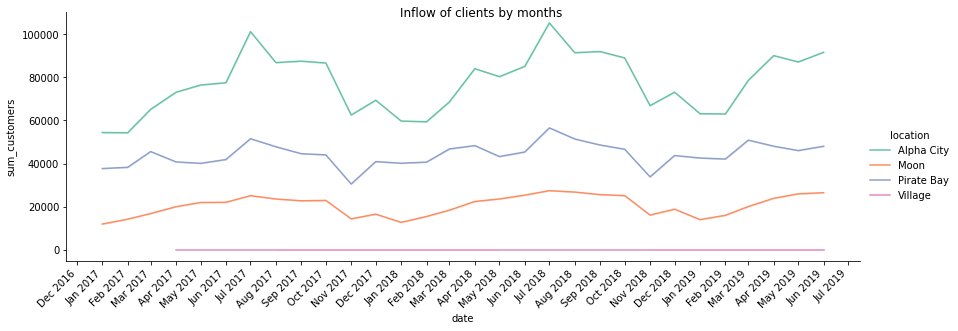

In [119]:
g=sns.relplot(
data=df_s_c,
x="date", y="sum_customers",
hue="location", 
kind="line", palette=colors_ira,
height=4, aspect=3, facet_kws=dict(sharex=False),
    )
g.ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=1))
g.ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(g.ax.get_xticklabels(), rotation=45, ha="right")
g.fig.suptitle('Inflow of clients by months');

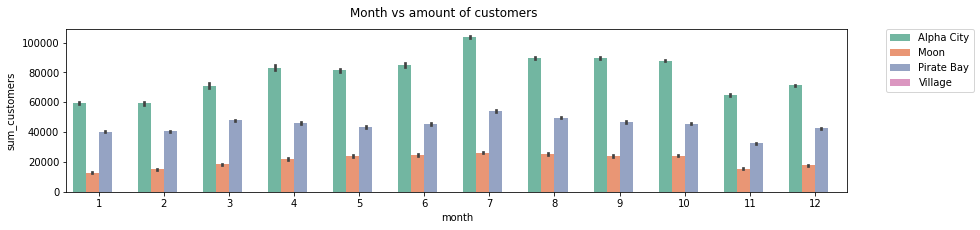

In [137]:
fsize = (14, 3)
fig, ax = plt.subplots(figsize=fsize)
fig.suptitle('Month vs amount of customers')
sns.barplot(data=df_s_c, x='month', y='sum_customers', hue='location', palette=colors_ira);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.); # Put the legend out of the figure

Наблюдается сезонность по потоку клиентов, годовой пик приходится на июль.  
Самый посещаемый город это Alpha City

Зависимость общих продаж от потока клиентов:

Т.к. поток клиентов в разы больше продаж то чтобы данные читались на графике нормализую их.

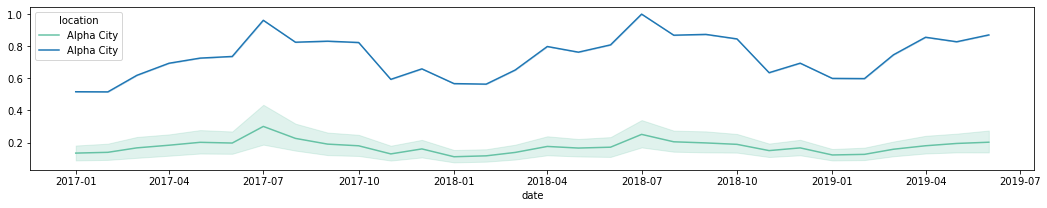

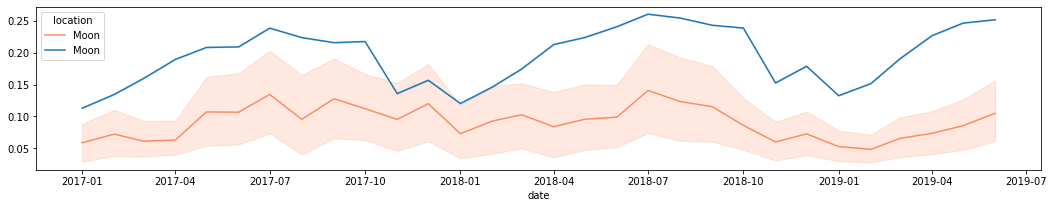

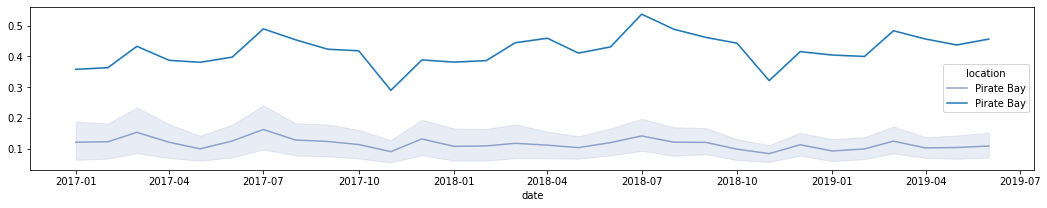

In [240]:
scaler_c = MinMaxScaler(feature_range=(0, 1))
scaler_v = MinMaxScaler(feature_range=(0, 1))

scaler_c = scaler_c.fit(df_s_c['sum_customers'].values.reshape(-1, 1))
scaler_v = scaler_v.fit(df_s_c['volume'].values.reshape(-1, 1))

for loc in df_s_c[df_s_c['location'] != 'Village']['location'].unique():
    
    data=df_s_c[df_s_c['location']==loc]
    
    sum_customers_scale = scaler_c.transform(data['sum_customers'].values.reshape(-1, 1))
    volume_scale = scaler_v.transform(data['volume'].values.reshape(-1, 1))
  
    fsize = (18, 3)
    fig, ax = plt.subplots(figsize=fsize)
    sns.lineplot(data=data, x='date', y=volume_scale.ravel(), hue='location', palette=colors_ira);
    sns.lineplot(data=data, x='date', y=sum_customers_scale.ravel(), hue='location');

Наблюдается практически линейная зависимость суммарных объемов продаж всех товаров с потоком клиентов.

### Прогнозирование

#### sku #79

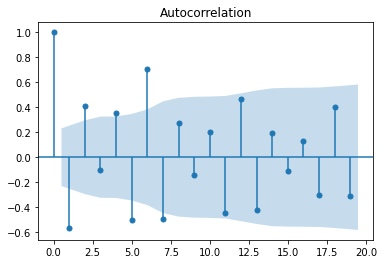

In [252]:
#Автокорреляция
plot_acf(df_s[(df_s['sku_id'] == 'sku #79')]['volume'])
plt.show()

In [259]:
df_s_c[df_s_c['sku_id']=='sku #79'][['volume', 'sum_customers']].corr()

volume  sum_customers
volume         1.00000        0.87937
sum_customers  0.87937        1.00000